In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.feature_selection import SelectKBest,mutual_info_classif

In [ ]:
df = pd.read_csv('Test/01_dataset.csv')
df.head()

customer_id  label  SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
0         1639      1               1.0             1.0              1.0   
1        23717      0              10.0             1.0              NaN   
2        19474      0               7.0             7.0              NaN   
3        15505      0               7.0             1.0              1.0   
4         1538      1               NaN             NaN              1.0   

   SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
0                    1.0                  1.0                   1.0   
1                    7.0                  1.0                   1.0   
2                    7.0                  NaN                   1.0   
3                    NaN                  1.0                   NaN   
4                    1.0                  1.0                   1.0   

   SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  ...  \
0                        1.0                      1.0  ...   
1                        4.0                      NaN  ...   
2                        1.0                      4.0  ...   
3                        7.0                      1.0  ...   
4                        1.0                      4.0  ...   

   ENQUIRIES_FROM_BANK_6M_9M  ENQUIRIES_FROM_BANK_9M_12M  \
0                        NaN                    2.000000   
1                   2.000000                    7.000000   
2                   7.000000                    5.571429   
3                   6.090909                    7.000000   
4                   2.000000                    2.000000   

   ENQUIRIES_FROM_BANK_6M_12M  ENQUIRIES_FROM_BANK_3M_12M  \
0                    2.000000                    2.000000   
1                    2.000000                    2.000000   
2                    5.571429                    5.571429   
3                         NaN                         NaN   
4                    2.000000                    2.000000   

   ENQUIRIES_FROM_NON_BANK_3M_6M  ENQUIRIES_FROM_NON_BANK_6M_9M  \
0                       7.000000                       3.666667   
1                       7.000000                       7.000000   
2                       7.000000                       7.000000   
3                       4.500000                       5.333333   
4                       3.666667                       7.000000   

   ENQUIRIES_FROM_NON_BANK_9M_12M  ENQUIRIES_FROM_NON_BANK_6M_12M  \
0                             7.0                        3.666667   
1                             7.0                        7.000000   
2                             7.0                        7.000000   
3                             7.0                        5.333333   
4                             7.0                        7.000000   

   ENQUIRIES_FROM_NON_BANK_3M_12M  OUTSTANDING_BAL_ALL_CURRENT  
0                        3.666667                    1000000.0  
1                        7.000000                          NaN  
2                        7.000000                    1000620.0  
3                        3.666667                    1000170.0  
4                        3.666667                    1000270.0  

[5 rows x 124 columns]

# Check validity

## Outliers

In [ ]:
# def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
#     quartile1 = dataframe[col_name].quantile(q1)
#     quartile3 = dataframe[col_name].quantile(q3)
#     interquantile_range = quartile3 - quartile1
#     up_limit = quartile3 + 1.5 * interquantile_range
#     low_limit = quartile1 - 1.5 * interquantile_range
#     return low_limit, up_limit

# def remove_outlier(dataframe, columns):
#     print(f'Shape before deleting outliers: {dataframe.shape}\n')
#     for col_name in columns:
#       low_limit, up_limit = outlier_thresholds(dataframe, col_name)
#       dataframe = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
#     print(f'Shape after deleting outliers: {dataframe.shape}')
#     return dataframe

# col_removing_outlier = df.select_dtypes('number').columns
# df = remove_outlier(df, col_removing_outlier)

In [ ]:
df.columns[df.columns.str.contains('NUMBER')]

Index(['NUMBER_OF_LOANS', 'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK',
       'NUMBER_OF_CREDIT_CARDS', 'NUMBER_OF_CREDIT_CARDS_BANK',
       'NUMBER_OF_CREDIT_CARDS_NON_BANK', 'NUMBER_OF_RELATIONSHIP',
       'NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT'],
      dtype='object')

## Float and negative

In [ ]:
cols = df.columns[df.columns.str.contains('ENQ')]
def is_true_float(x):
    return isinstance(x, float) and not np.isnan(x) and x != int(x)

def is_true_nega(x):
    return x < 0

def is_positive(x):
    return x >= 0

def check_float(df, columns):
    check_float_dict = {}
    for col in columns:
        total_values = len(df[col])
        float_count = df[col].apply(is_true_float).sum()
        check_float_dict[col] = (float_count / total_values) * 100
    return check_float_dict

def check_nega(df, columns):
    check_nega_dict = {}
    for col in columns:
        total_values = len(df[col])
        nega_count = df[col].apply(is_true_nega).sum()
        check_nega_dict[col] = (nega_count / total_values) * 100
    return check_nega_dict

float_percentages = check_float(df, cols)
float_columns = []
for column, percentage in float_percentages.items():
    if percentage == 0: continue
    print(f"{column}: {percentage:.2f}% of values are floats.")
    float_columns.append(column)
print('-' * 50)
nega_percentages = check_nega(df, cols)
nega_columns = []
for column, percentage in nega_percentages.items():
    if percentage == 0: continue
    print(f"{column}: {percentage:.2f}% of values are negas.")
    nega_columns.append(column)

neg_float = len(df.loc[~(df[float_columns].applymap(is_true_float).any(axis=1)) & (df[float_columns].applymap(is_positive).all(axis=1))])
neg = len(df.loc[(df[float_columns].applymap(is_positive).all(axis=1))])
_float = len(df.loc[~(df[float_columns].applymap(is_true_float).any(axis=1))])

print('\n')
print(f'Number of rows left when deleting both negative and float value in ENQUIRIES: {neg_float}')
print(f'Number of rows left when deleting negative value in ENQUIRIES: {neg}')
print(f'Number of rows left when deleting float value in ENQUIRIES: {_float}')

ENQUIRIES_3M_6M: 24.57% of values are floats.
ENQUIRIES_6M_9M: 20.92% of values are floats.
ENQUIRIES_9M_12M: 18.29% of values are floats.
ENQUIRIES_6M_12M: 29.33% of values are floats.
ENQUIRIES_3M_12M: 39.72% of values are floats.
ENQUIRIES_FROM_BANK_3M_6M: 7.39% of values are floats.
ENQUIRIES_FROM_BANK_6M_9M: 9.28% of values are floats.
ENQUIRIES_FROM_BANK_9M_12M: 9.41% of values are floats.
ENQUIRIES_FROM_BANK_6M_12M: 12.46% of values are floats.
ENQUIRIES_FROM_BANK_3M_12M: 11.87% of values are floats.
ENQUIRIES_FROM_NON_BANK_3M_6M: 15.85% of values are floats.
ENQUIRIES_FROM_NON_BANK_6M_9M: 11.92% of values are floats.
ENQUIRIES_FROM_NON_BANK_9M_12M: 8.95% of values are floats.
ENQUIRIES_FROM_NON_BANK_6M_12M: 17.70% of values are floats.
ENQUIRIES_FROM_NON_BANK_3M_12M: 27.88% of values are floats.
--------------------------------------------------
ENQUIRIES_FROM_BANK_3M_6M: 41.32% of values are negas.
ENQUIRIES_FROM_BANK_6M_9M: 37.30% of values are negas.
ENQUIRIES_FROM_BANK_9M_1

C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3277368830.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neg_float = len(df.loc[~(df[float_columns].applymap(is_true_float).any(axis=1)) & (df[float_columns].applymap(is_positive).all(axis=1))])
C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3277368830.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neg_float = len(df.loc[~(df[float_columns].applymap(is_true_float).any(axis=1)) & (df[float_columns].applymap(is_positive).all(axis=1))])
C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3277368830.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neg = len(df.loc[(df[float_columns].applymap(is_positive).all(axis=1))])
C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3277368830.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _float = len(df.loc[~(df[float_columns].applyma



Number of rows left when deleting both negative and float value in ENQUIRIES: 912
Number of rows left when deleting negative value in ENQUIRIES: 2259
Number of rows left when deleting float value in ENQUIRIES: 10192


In [ ]:
df[['ENQUIRIES_FROM_BANK_3M_6M',
 'ENQUIRIES_FROM_BANK_6M_9M',
 'ENQUIRIES_FROM_BANK_9M_12M',
 'ENQUIRIES_FROM_BANK_6M_12M',
 'ENQUIRIES_FROM_BANK_3M_12M']].applymap(lambda x: 0, inplace=True)

C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3397276578.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'ENQUIRIES_FROM_BANK_3M_12M']].applymap(lambda x: 0, inplace=True)


TypeError: <lambda>() got an unexpected keyword argument 'inplace'

# EDA

Comment:
1. **Group 1:** Nhóm số lượng khoản vay **theo thời gian** ('SHORT_TERM_COUNT', 'MID_TERM_COUNT', ..., 'LONG_TERM_COUNT_NON_BANK')
- Mean nhóm 0 luôn lớn hơn nhóm 1 từ ~0%-40%

- Distribution short_term_count của nhóm 0 có xu hướng lớn hơn nhóm 1 (Dịch: Đối với nhóm khoản vay ngắn hạn, nhóm 0 tập trung chủ yếu ở 4-7 khoản vay trong khi nhóm 1 tập trung vào 1 khoản vay). Còn lại distribution khá giống nhau
2. **Group 2:** Nhóm tổng số lượng khoản vay, số lượng thẻ tín dụng, số lượng mối quan hệ tài chính, số lượng khoản vay tạo mới qua từng tháng (NUMBER_OF_LOANS_,NUMBER_OF_CREDIT_CARDS_,NUMBER_OF_RELATIONSHIP_, NUM_NEW_LOAN_TAKEN_xM)
- Mean nhóm 0 luôn lớn hơn nhóm 1 từ ~20-50%
- Đối với distribution tổng số khoản vay bất kể bank or non-bank (Number_of_loan): Nhóm 0 luôn tập trung vào 4-7 khoản vay  trong khi nhóm 1 luôn tập trung vào 1 khoản vay .

- Đối với distribution tổng số thẻ tín dụng (NUMBER_OF_CC): Nhóm 0 và 1 khá tương đồng khi tập trung chủ yếu ở số thẻ là 1-4

- Đối với distribution tổng số mối quan hệ (NUMBER OF RELATIONSHIP): Nhóm 0 tập trung vào 4-10 mối quan hệ trong khi nhóm 1 chỉ tập trung ở khoảng 1-4

- Đối với distribution số khoản vay mới (NUM_NEW_LOAN_TAKEN_XM):
    - Trong 3 tháng trước: Nhóm 0 có sự phân phối lớn nhất và đều ở 1 và 4 khoản vay mới
    - Trong 6-9-12 tháng trước: Nhóm 0 có sự phân phối lớn nhất ở 4-7 khoản vay mới
    - Trong suốt 3-6-9-12 tháng trước: Nhóm 1 luôn có sự phân phối lớn nhất ở 1 khoản vay mới
3. **Group 3:** Nhóm số dư (tất cả các cột bắt đầu bằng OUTSTANDING_BAL_...)
- Không có sự chênh lệch nào đáng kể giữa 2 label 0 và 1 (chênh lệch lớn nhất chắc chưa đến 1%)
- distribution khó tìm điểm khác nhau

4. **Group 4** Nhóm INCREASING
- Useless

5. **Group 5** Nhóm số lần trễ hạn và số tháng trôi qua kể từ lần cuối thanh toán quá hạn (NUMBER_OF_LATE_PAYMENT & CREDIT_CARD_MONTH_SINCE)
- Useless

6. **Group 6** Nhóm tra cứu (ENQUIRIES)
- Useless


### Group 1

#### mean

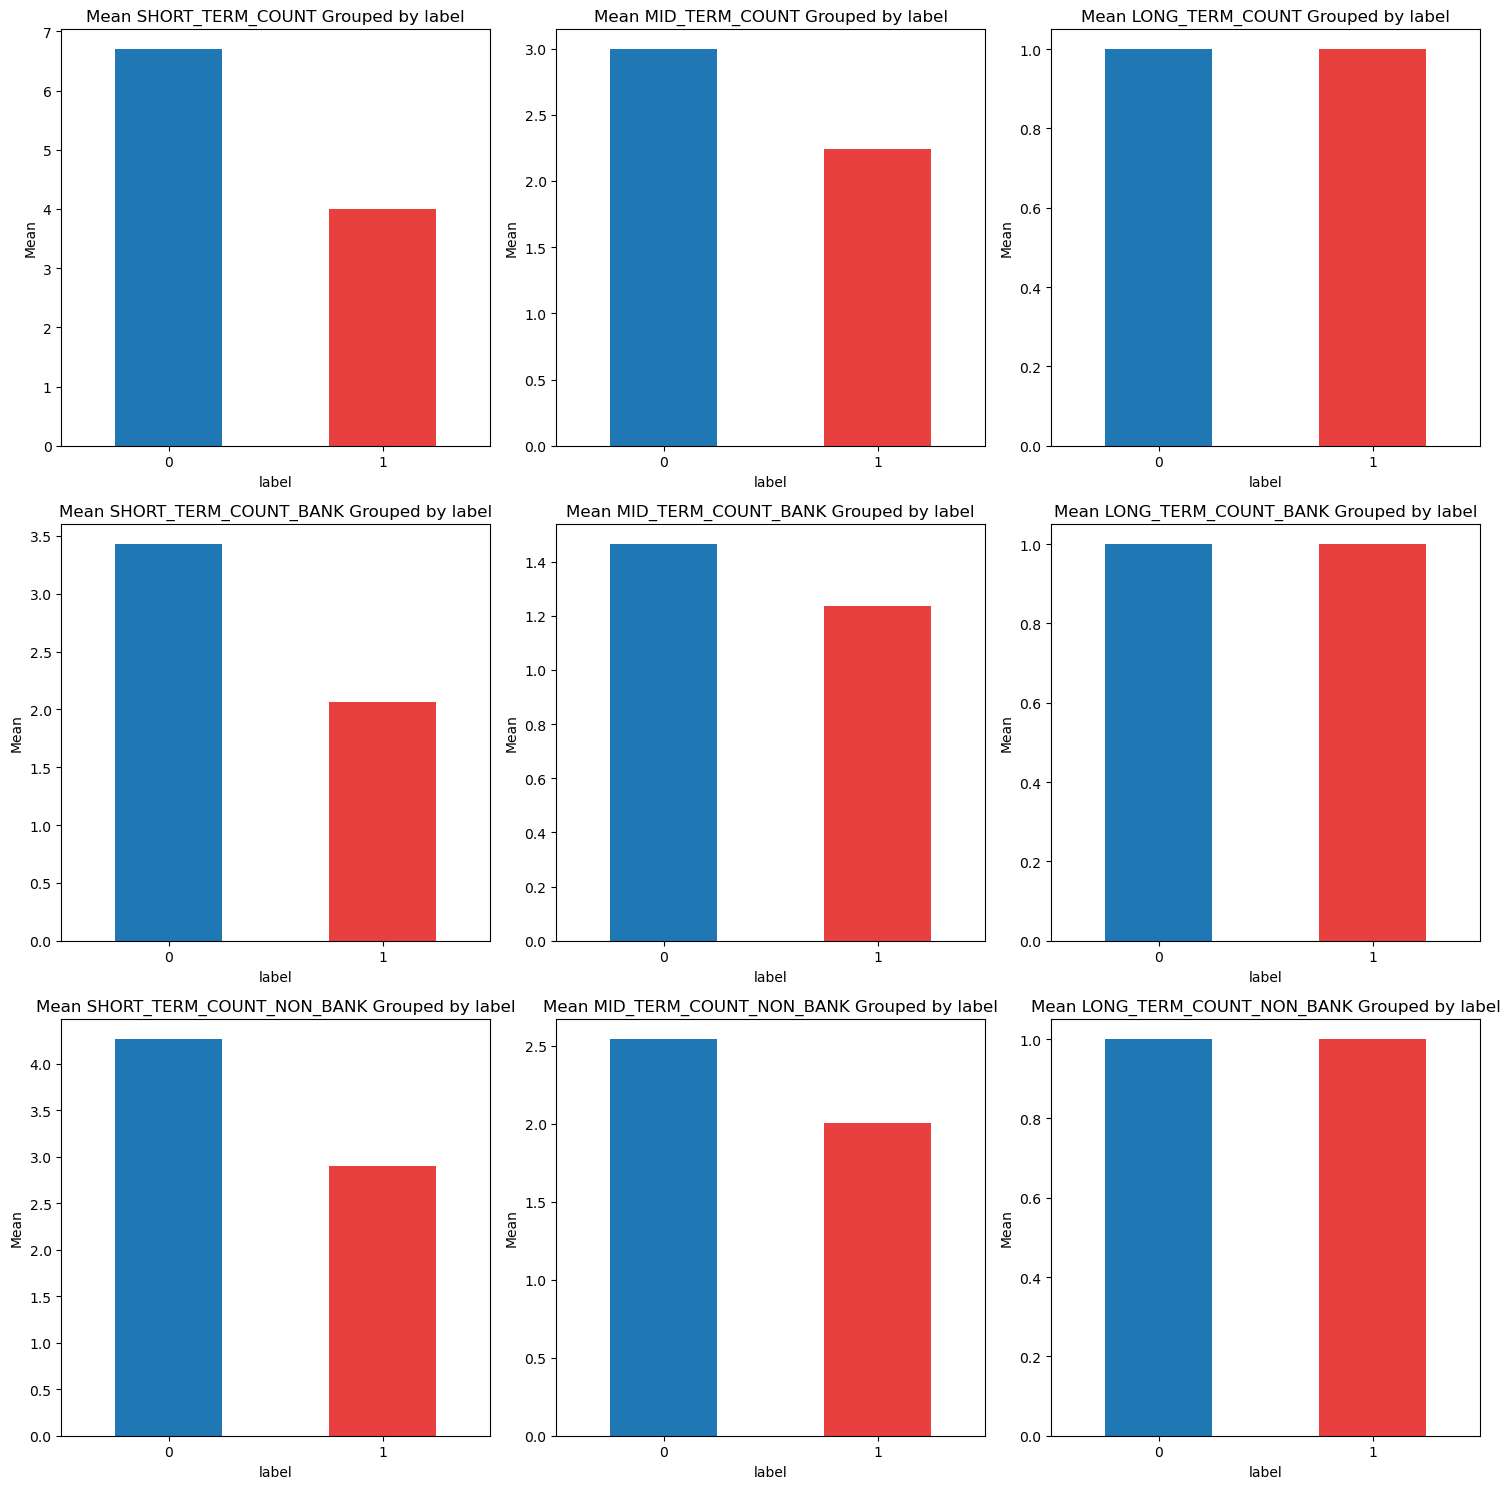

In [ ]:
columns = df.columns[df.columns.str.contains('COUNT')]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#E83F3F'])  # Customize colors if needed
    axes[i].set_title(f'Mean {col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distribution

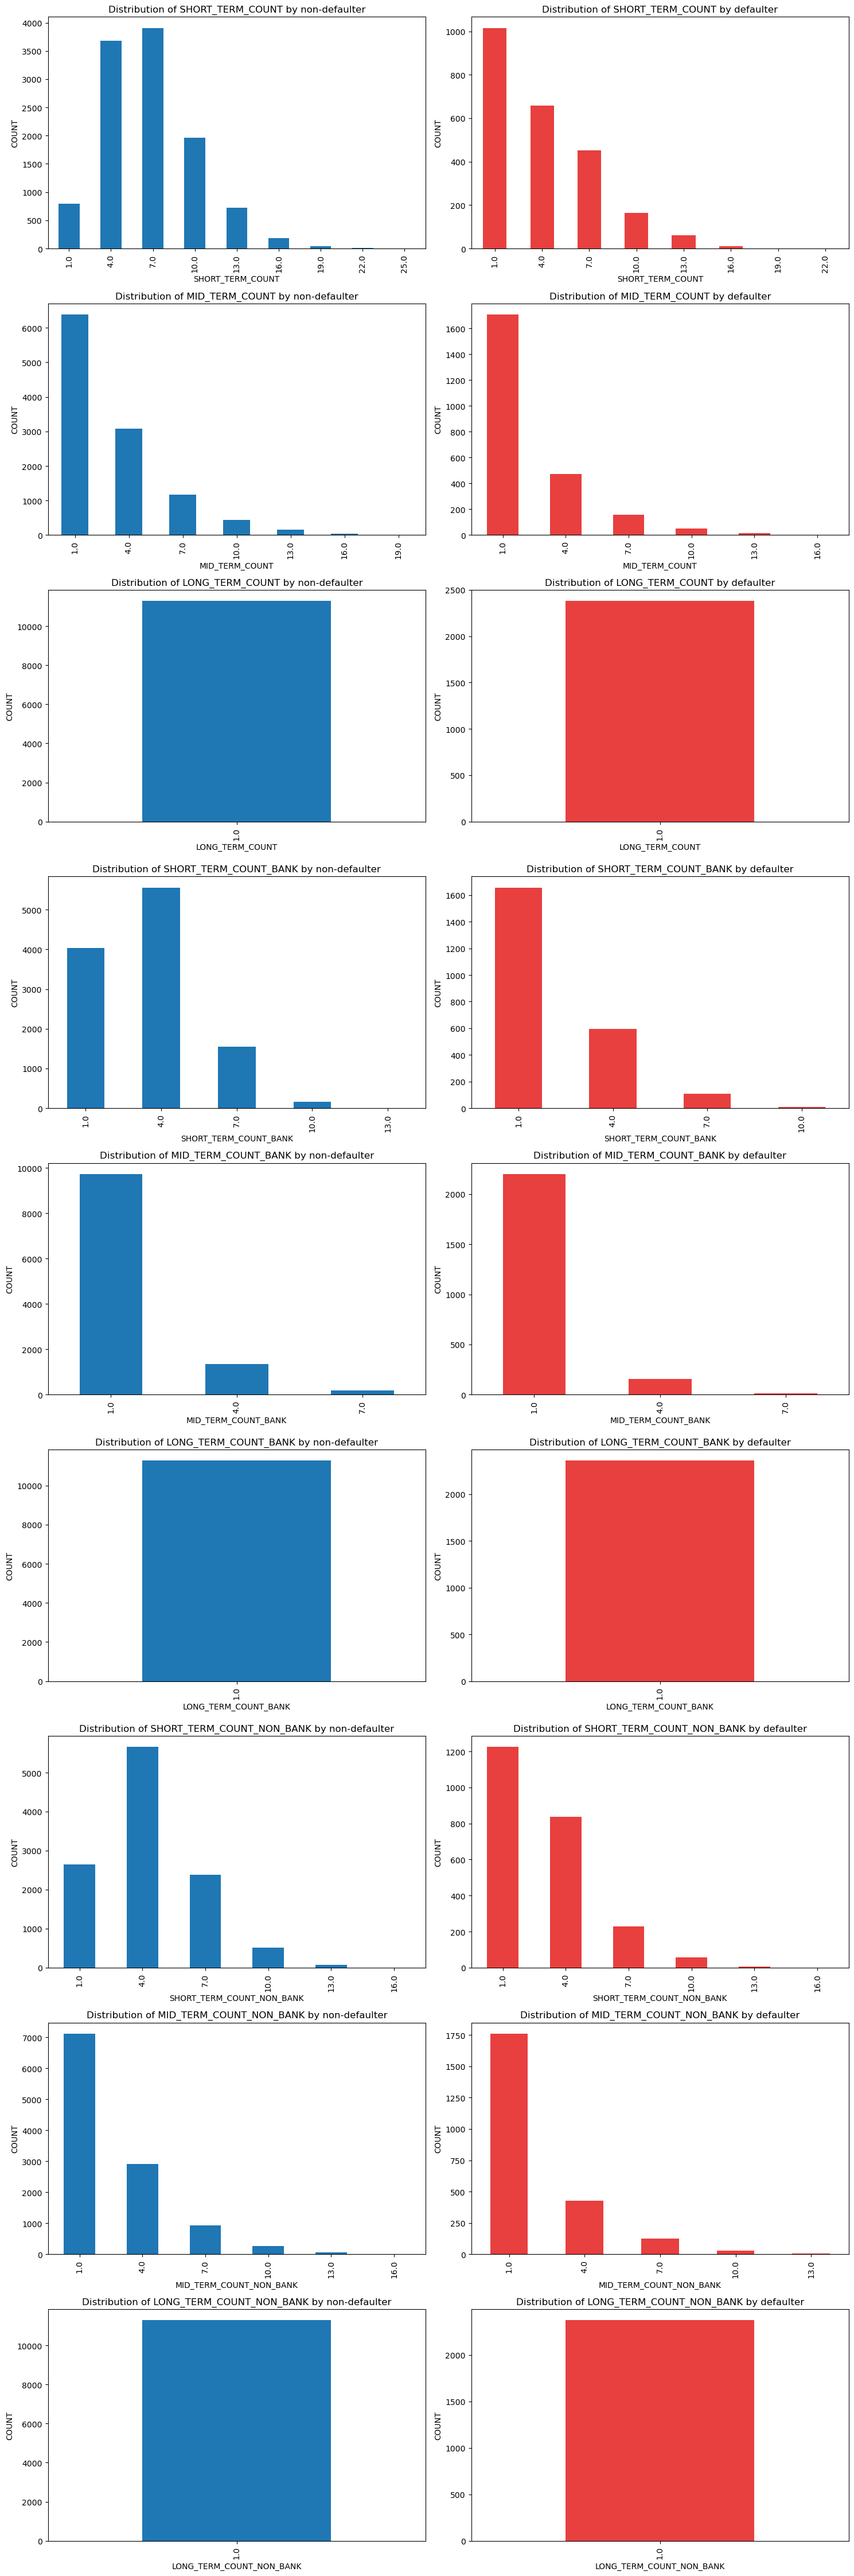

In [ ]:
# số khoản vay

columns = ['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT',
       'SHORT_TERM_COUNT_BANK', 'MID_TERM_COUNT_BANK', 'LONG_TERM_COUNT_BANK',
       'SHORT_TERM_COUNT_NON_BANK', 'MID_TERM_COUNT_NON_BANK',
       'LONG_TERM_COUNT_NON_BANK']
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
# axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    for j in range(n_cols):
        if j == 1:
            d = df.loc[df['label'] == 1, col].value_counts().sort_index()
            d.plot(kind='bar', ax=axes[i, j], color='#E83F3F')  # Customize colors if needed
            axes[i, j].set_title(f'Distribution of {col} by defaulter')
            axes[i, j].set_xlabel(col)
            axes[i, j].set_ylabel('COUNT')
        else:
            nd = df.loc[df['label'] == 0, col].value_counts().sort_index()
            nd.plot(kind='bar', ax=axes[i, j],)
            axes[i, j].set_title(f'Distribution of {col} by non-defaulter')
            axes[i, j].set_xlabel(col)
            axes[i, j].set_ylabel('COUNT')

# Hide any remaining empty subplots if columns don't fill the entire grid


plt.tight_layout()
plt.show()

### Group 2

#### mean

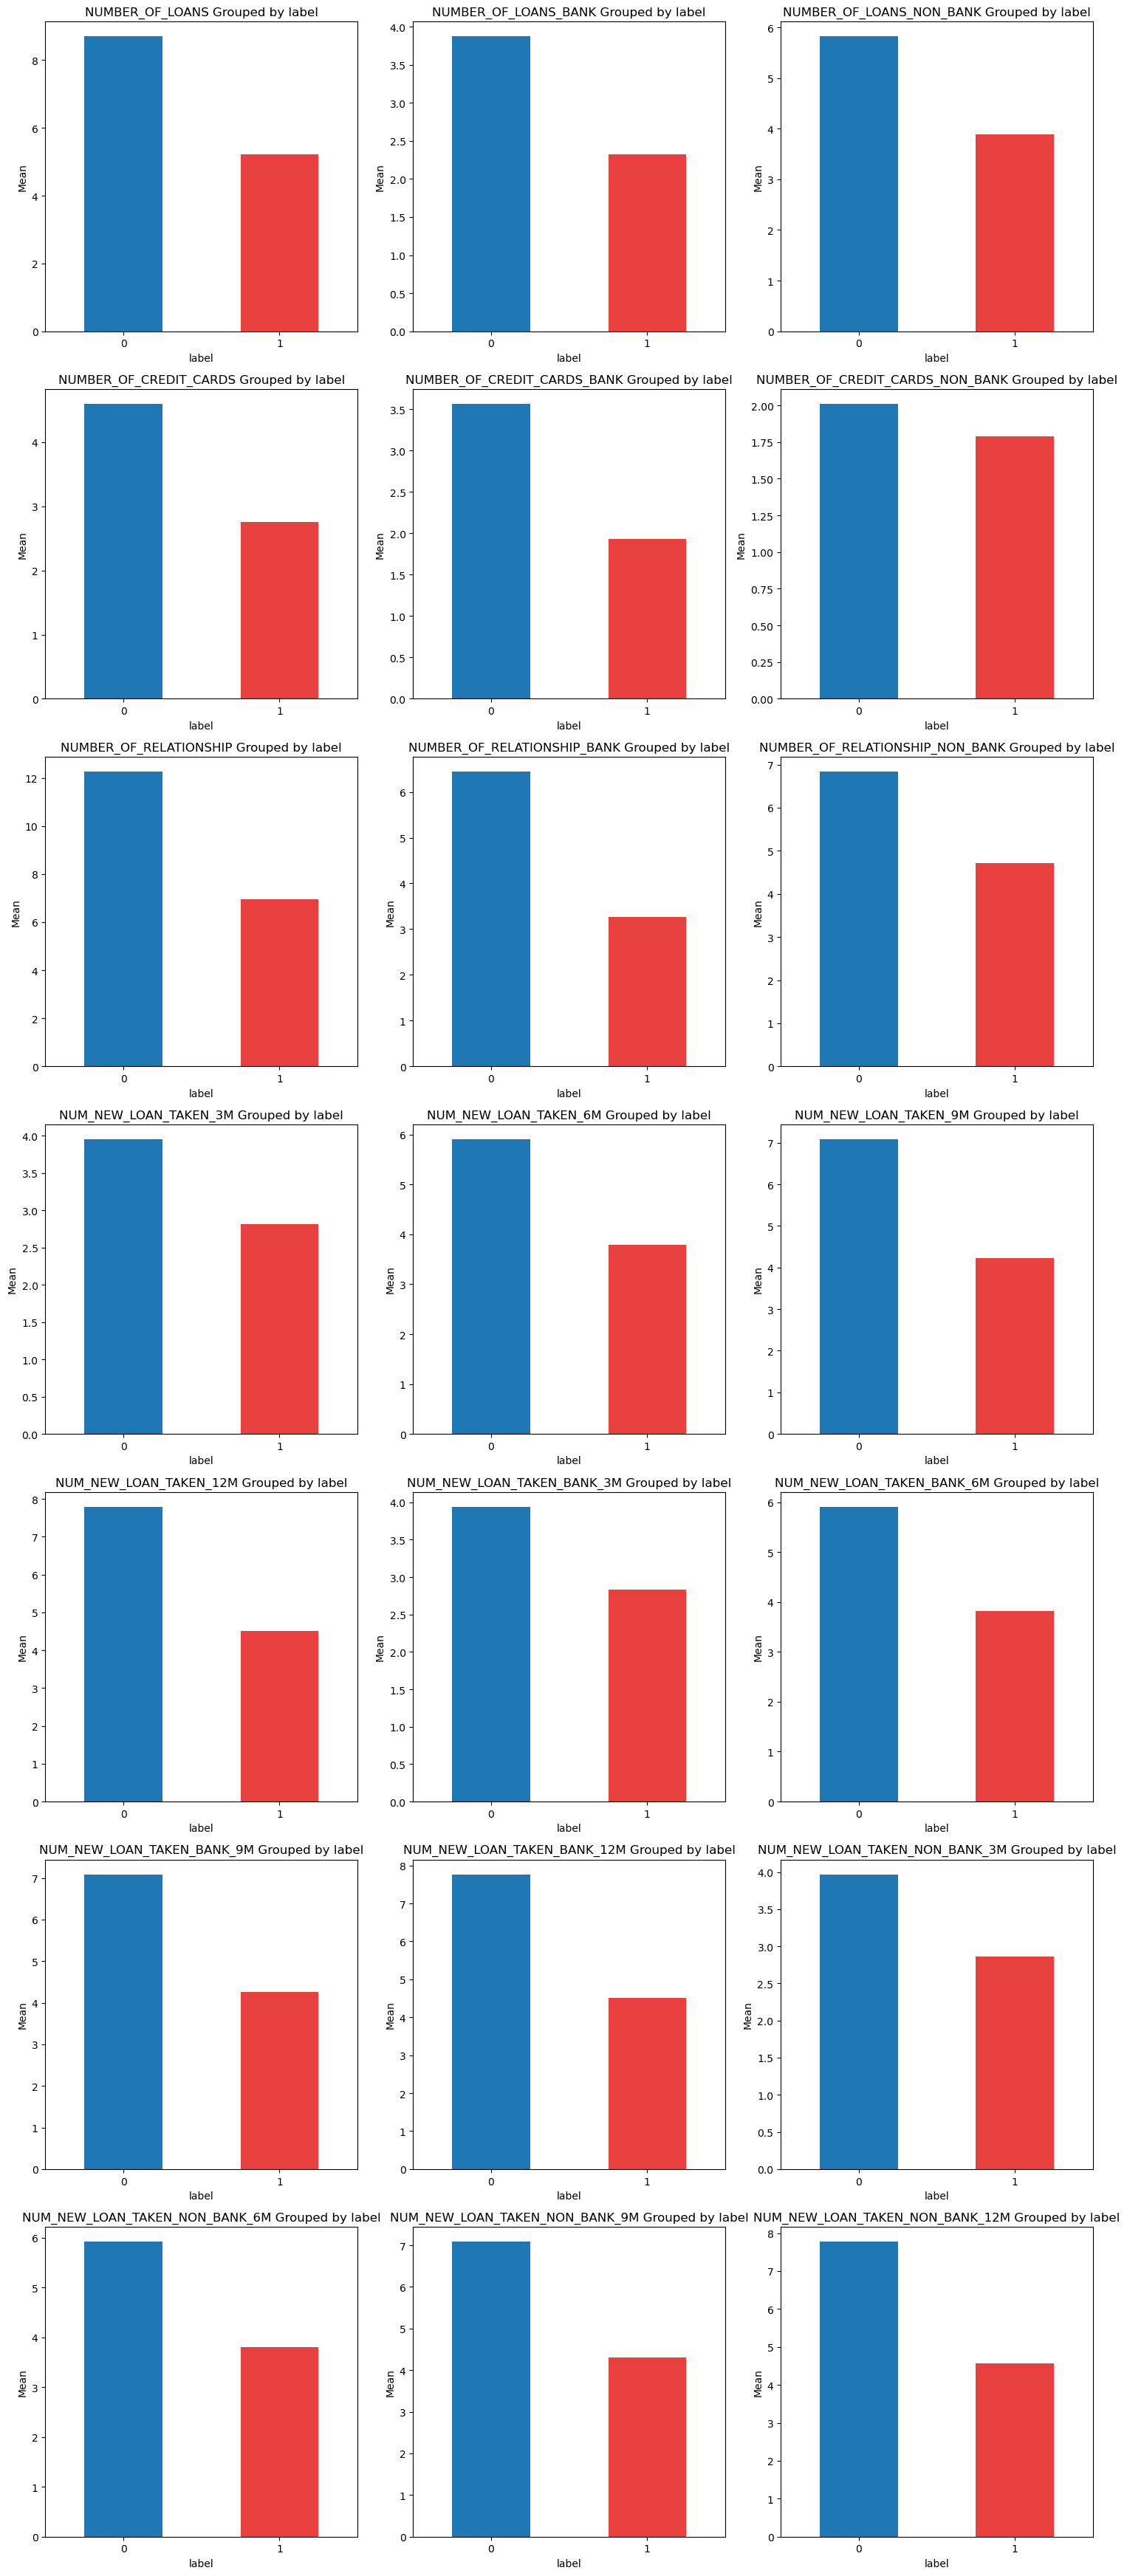

In [ ]:
columns = df.columns[df.columns.str.contains('NUM')]
columns = columns[:-1]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#E83F3F'])  # Customize colors if needed
    axes[i].set_title(f'{col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distribution

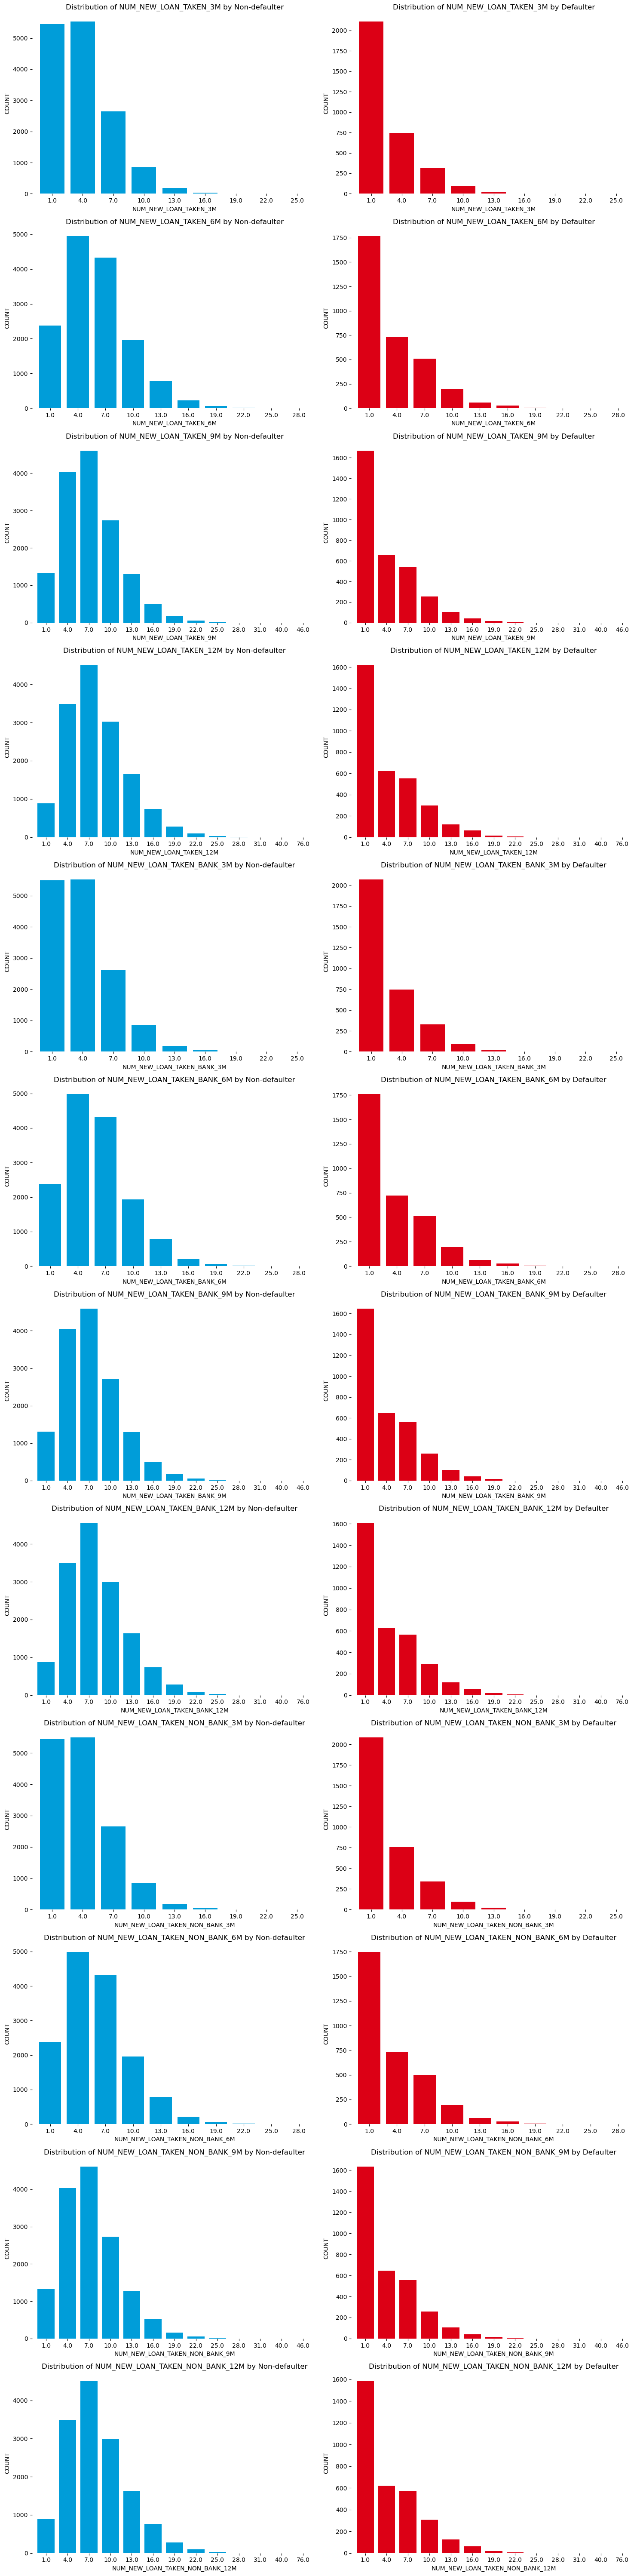

In [ ]:
columns = df.columns[df.columns.str.contains('NEW_LOAN')]
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
# axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    d = df.loc[df['label'] == 1, col].value_counts().sort_index()
    nd = df.loc[df['label'] == 0, col].value_counts().sort_index()

    # Combine the two Series into a single DataFrame for aligned plotting
    combined_df = pd.DataFrame({'Default': d, 'Non-default': nd})


    # Plot for non-defaults
    combined_df['Non-default'].plot(kind='bar', ax=axes[i, 0], color='#009dd9', width=0.8)
    axes[i, 0].set_title(f'Distribution of {col} by Non-defaulter')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('COUNT')
    axes[i, 0].tick_params(axis='x', rotation=0)

    # Plot for defaults
    combined_df['Default'].plot(kind='bar', ax=axes[i, 1], color='#dc0015', width=0.8)
    axes[i, 1].set_title(f'Distribution of {col} by Defaulter')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('COUNT')
    axes[i, 1].tick_params(axis='x', rotation=0)

    for i in range(len(axes)):
        axes[i, 0].spines['left'].set_visible(False)
        axes[i, 0].spines['top'].set_visible(False)
        axes[i, 0].spines['right'].set_visible(False)
        axes[i, 0].spines['bottom'].set_visible(False)
        axes[i, 1].spines['left'].set_visible(False)
        axes[i, 1].spines['bottom'].set_visible(False)
        axes[i, 1].spines['right'].set_visible(False)
        axes[i, 1].spines['top'].set_visible(False)
# Hide any remaining empty subplots if columns don't fill the entire grid


plt.tight_layout()
plt.show()

### Group 3

#### mean

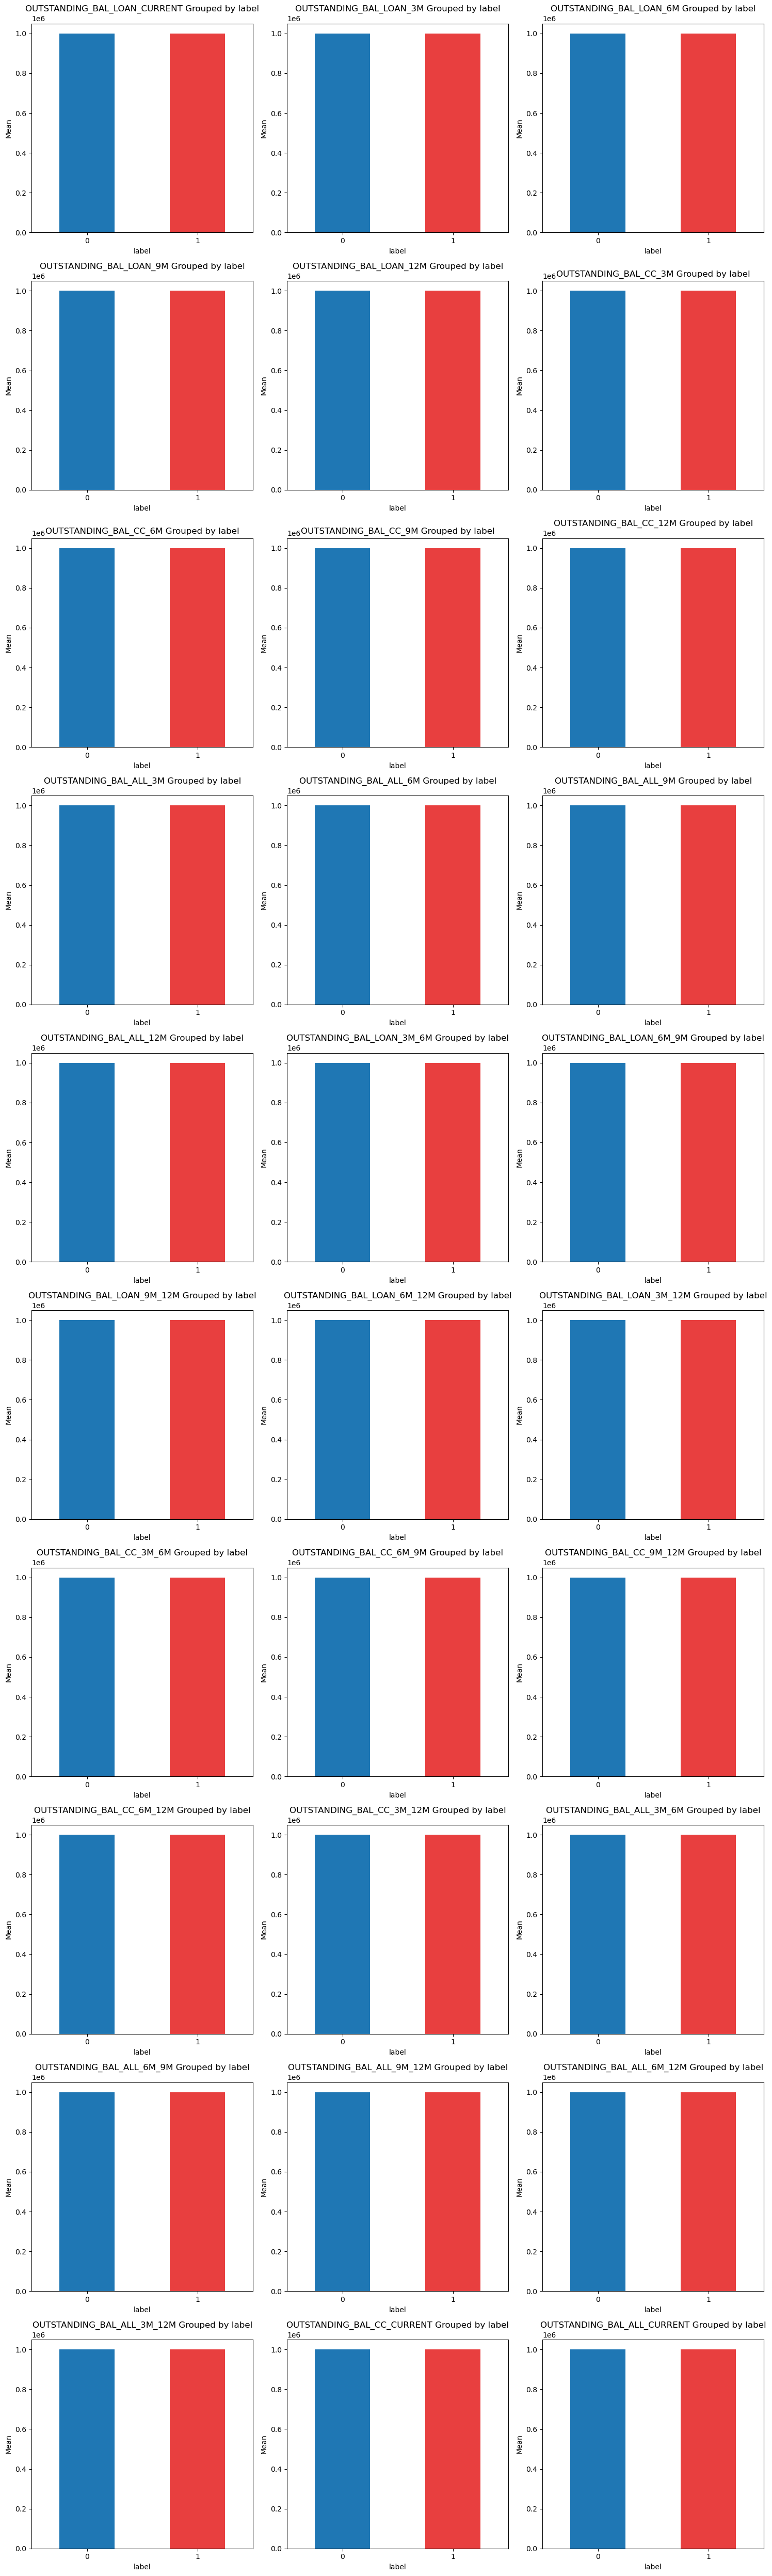

In [ ]:
columns = df.columns[df.columns.str.contains('OUTS')]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#E83F3F'])  # Customize colors if needed
    axes[i].set_title(f'{col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distribution

C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1562027115.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.loc[df['label'] == 1].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1562027115.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nd = df.loc[df['label'] == 0].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1562027115.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

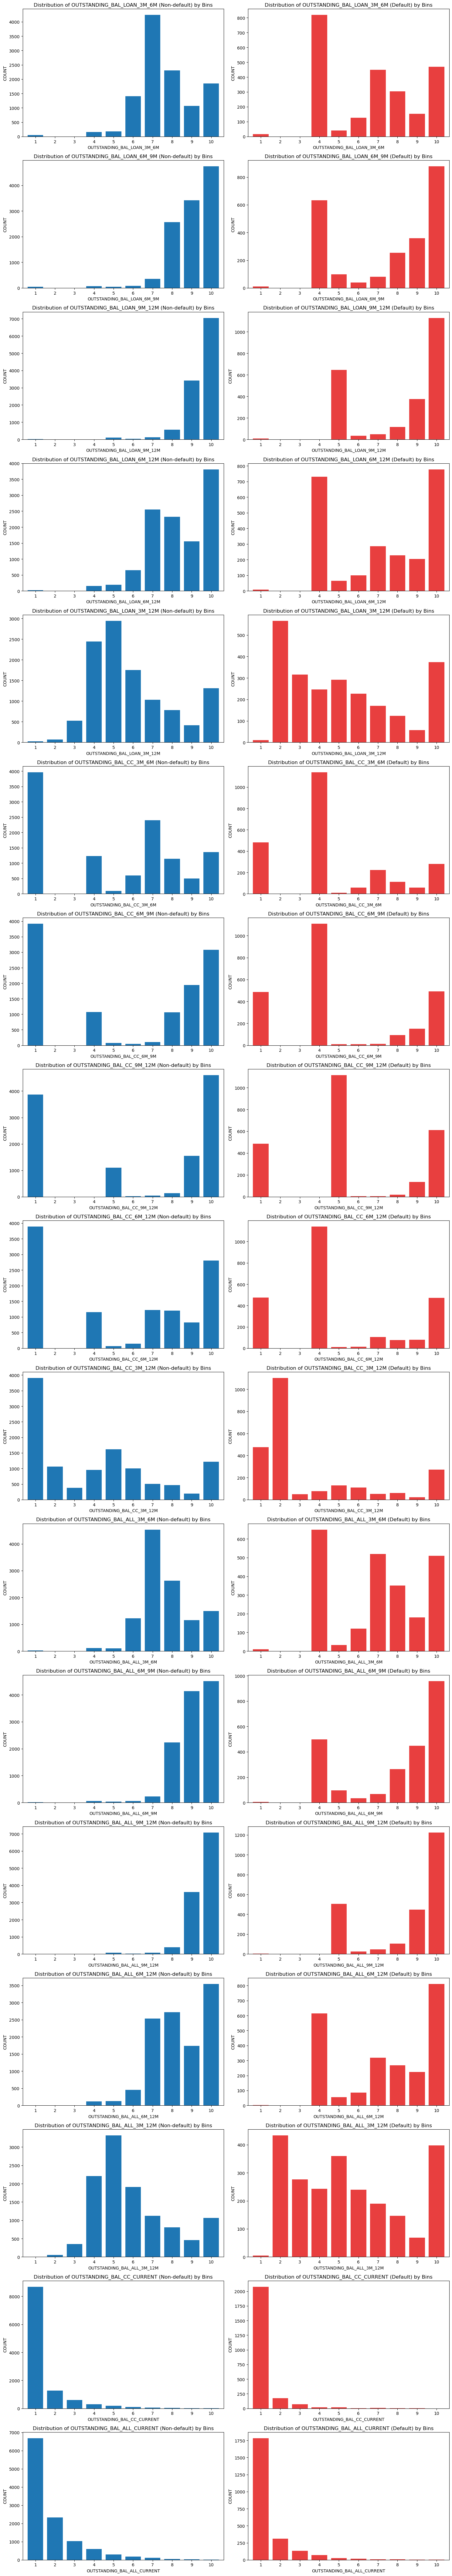

In [ ]:
columns = df.columns[df.columns.str.contains('OUTS')][13:]
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each column and plot the binned data grouped by the binary label
for i, col in enumerate(columns):
    # Define the binning (5 bins)
    bins = 10
    bin_edges = pd.cut(df[col], bins=bins, labels=range(1, bins+1))

    # Value counts for defaults and non-defaults, after binning
    d = df.loc[df['label'] == 1].groupby(bin_edges)[col].count()
    nd = df.loc[df['label'] == 0].groupby(bin_edges)[col].count()

    # Combine the two Series into a single DataFrame for aligned plotting
    combined_df = pd.DataFrame({'Default': d, 'Non-default': nd}).fillna(0)

    # Plot for non-defaults
    combined_df['Non-default'].plot(kind='bar', ax=axes[i, 0], color='#1f77b4', width=0.8)
    axes[i, 0].set_title(f'Distribution of {col} (Non-default) by Bins')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('COUNT')
    axes[i, 0].tick_params(axis='x', rotation=0)

    # Plot for defaults
    combined_df['Default'].plot(kind='bar', ax=axes[i, 1], color='#E83F3F', width=0.8)
    axes[i, 1].set_title(f'Distribution of {col} (Default) by Bins')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('COUNT')
    axes[i, 1].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Group 4

#### mean

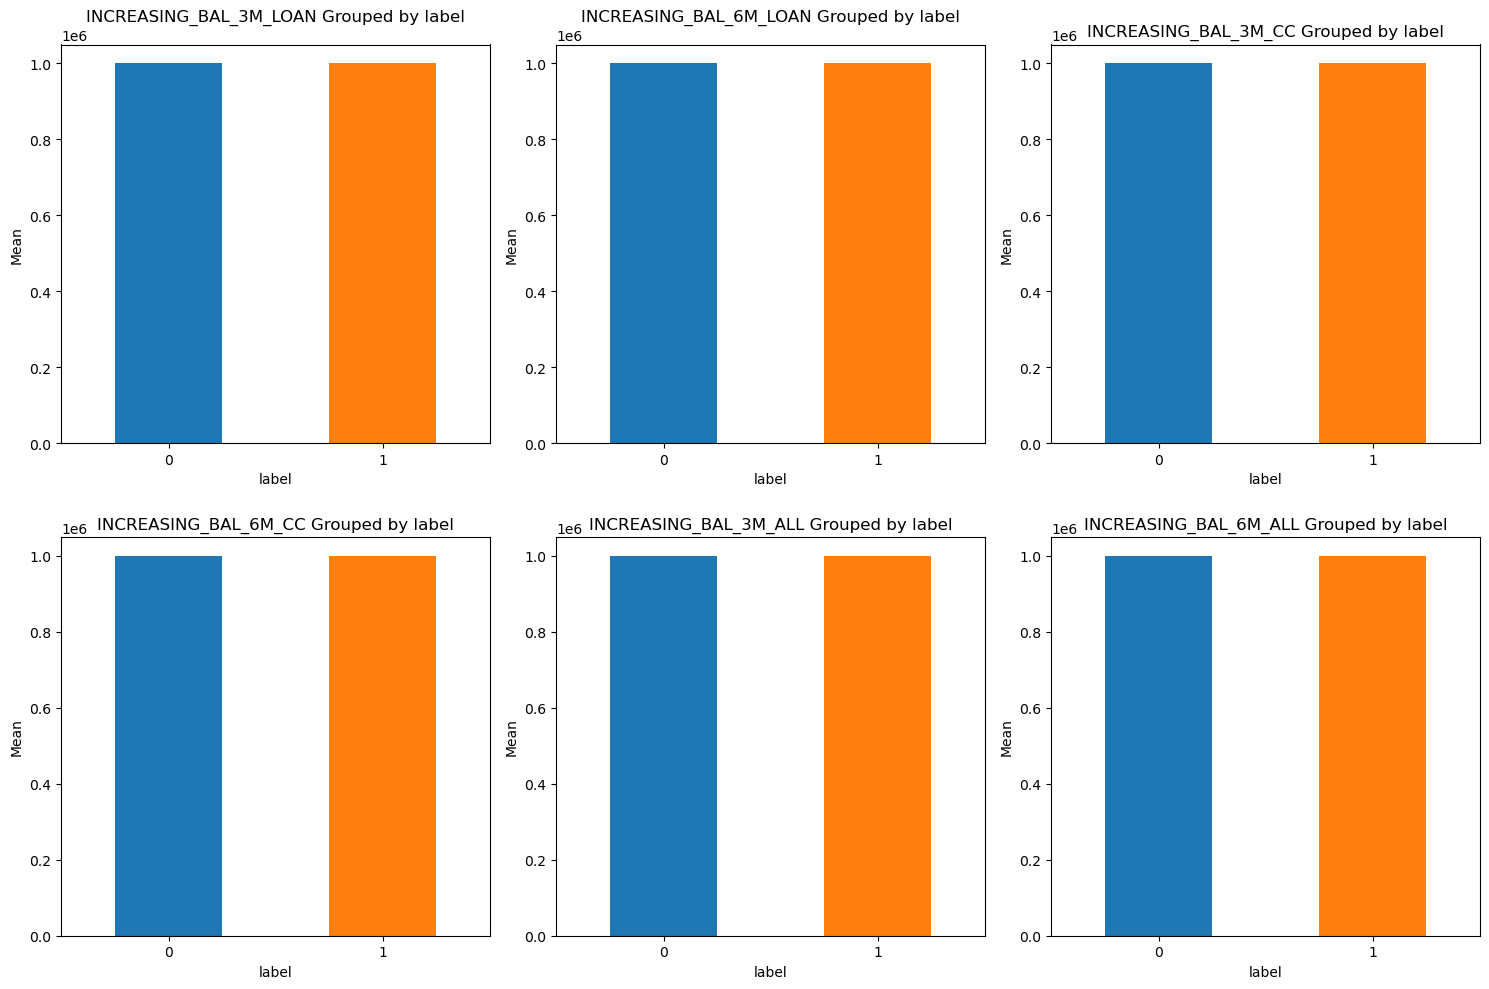

In [ ]:
columns = df.columns[df.columns.str.contains('INCREASING')]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#ff7f0e'])  # Customize colors if needed
    axes[i].set_title(f'{col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distributino

C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1744569182.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.loc[df['label'] == 1].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1744569182.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nd = df.loc[df['label'] == 0].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\1744569182.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

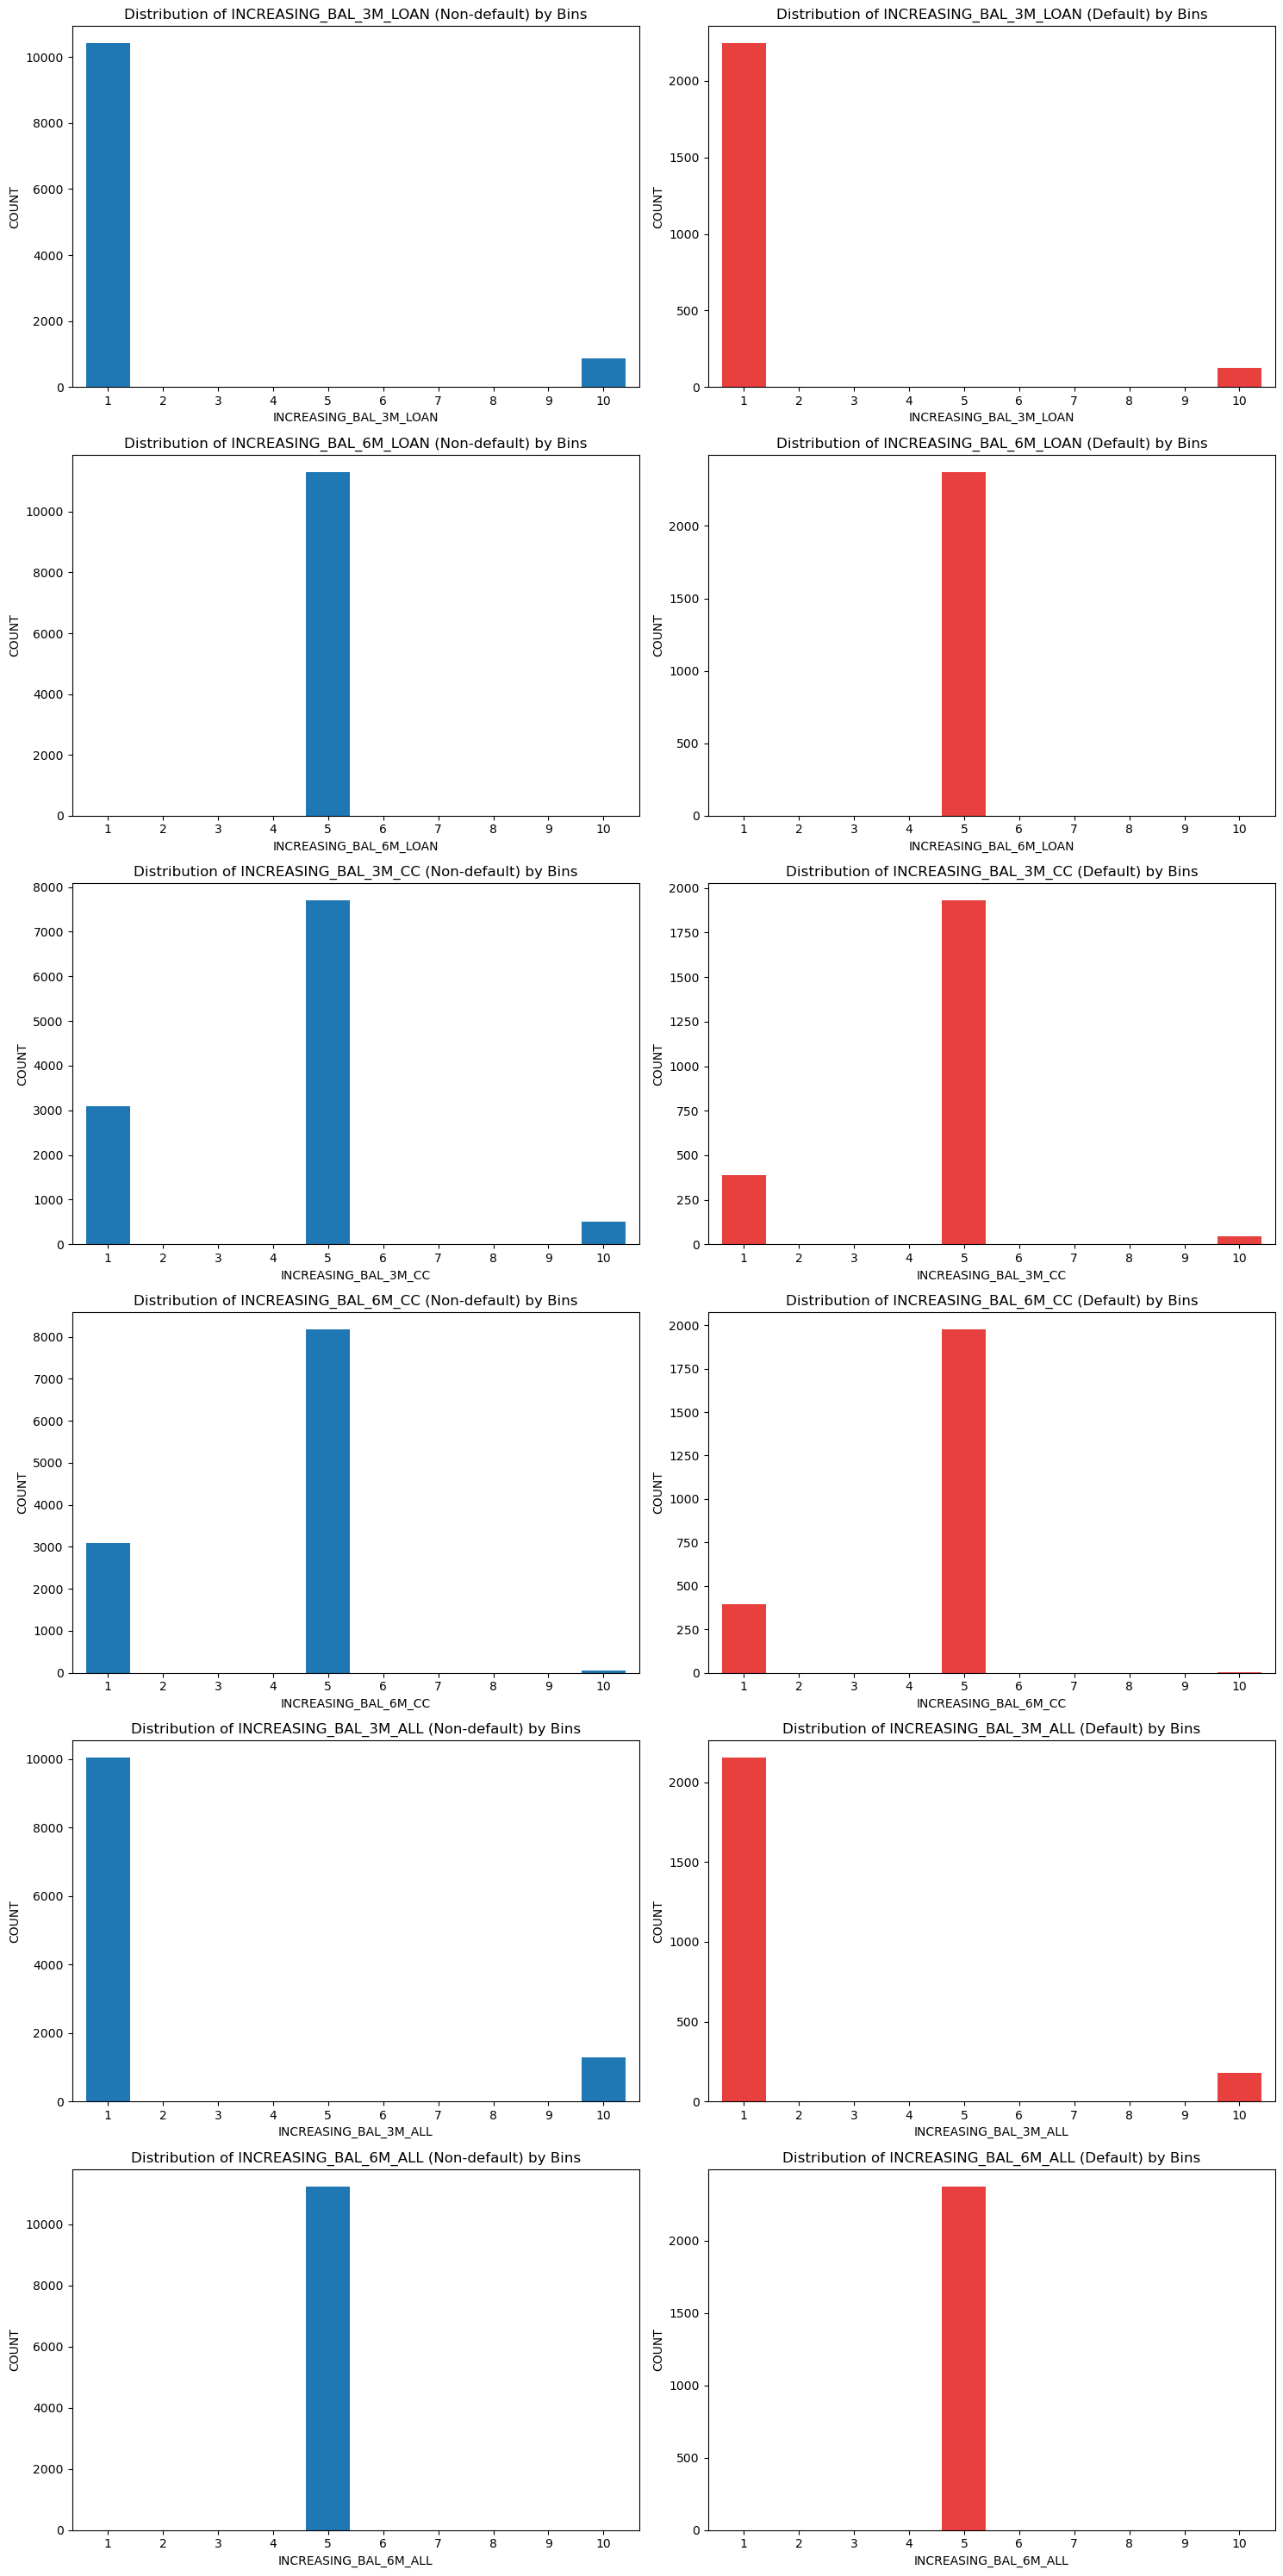

In [ ]:
columns = df.columns[df.columns.str.contains('INCREASING')]
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each column and plot the binned data grouped by the binary label
for i, col in enumerate(columns):
    # Define the binning (5 bins)
    bins = 10
    bin_edges = pd.cut(df[col], bins=bins, labels=range(1, bins+1))

    # Value counts for defaults and non-defaults, after binning
    d = df.loc[df['label'] == 1].groupby(bin_edges)[col].count()
    nd = df.loc[df['label'] == 0].groupby(bin_edges)[col].count()

    # Combine the two Series into a single DataFrame for aligned plotting
    combined_df = pd.DataFrame({'Default': d, 'Non-default': nd}).fillna(0)

    # Plot for non-defaults
    combined_df['Non-default'].plot(kind='bar', ax=axes[i, 0], color='#1f77b4', width=0.8)
    axes[i, 0].set_title(f'Distribution of {col} (Non-default) by Bins')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('COUNT')
    axes[i, 0].tick_params(axis='x', rotation=0)

    # Plot for defaults
    combined_df['Default'].plot(kind='bar', ax=axes[i, 1], color='#E83F3F', width=0.8)
    axes[i, 1].set_title(f'Distribution of {col} (Default) by Bins')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('COUNT')
    axes[i, 1].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Group 5

#### mean

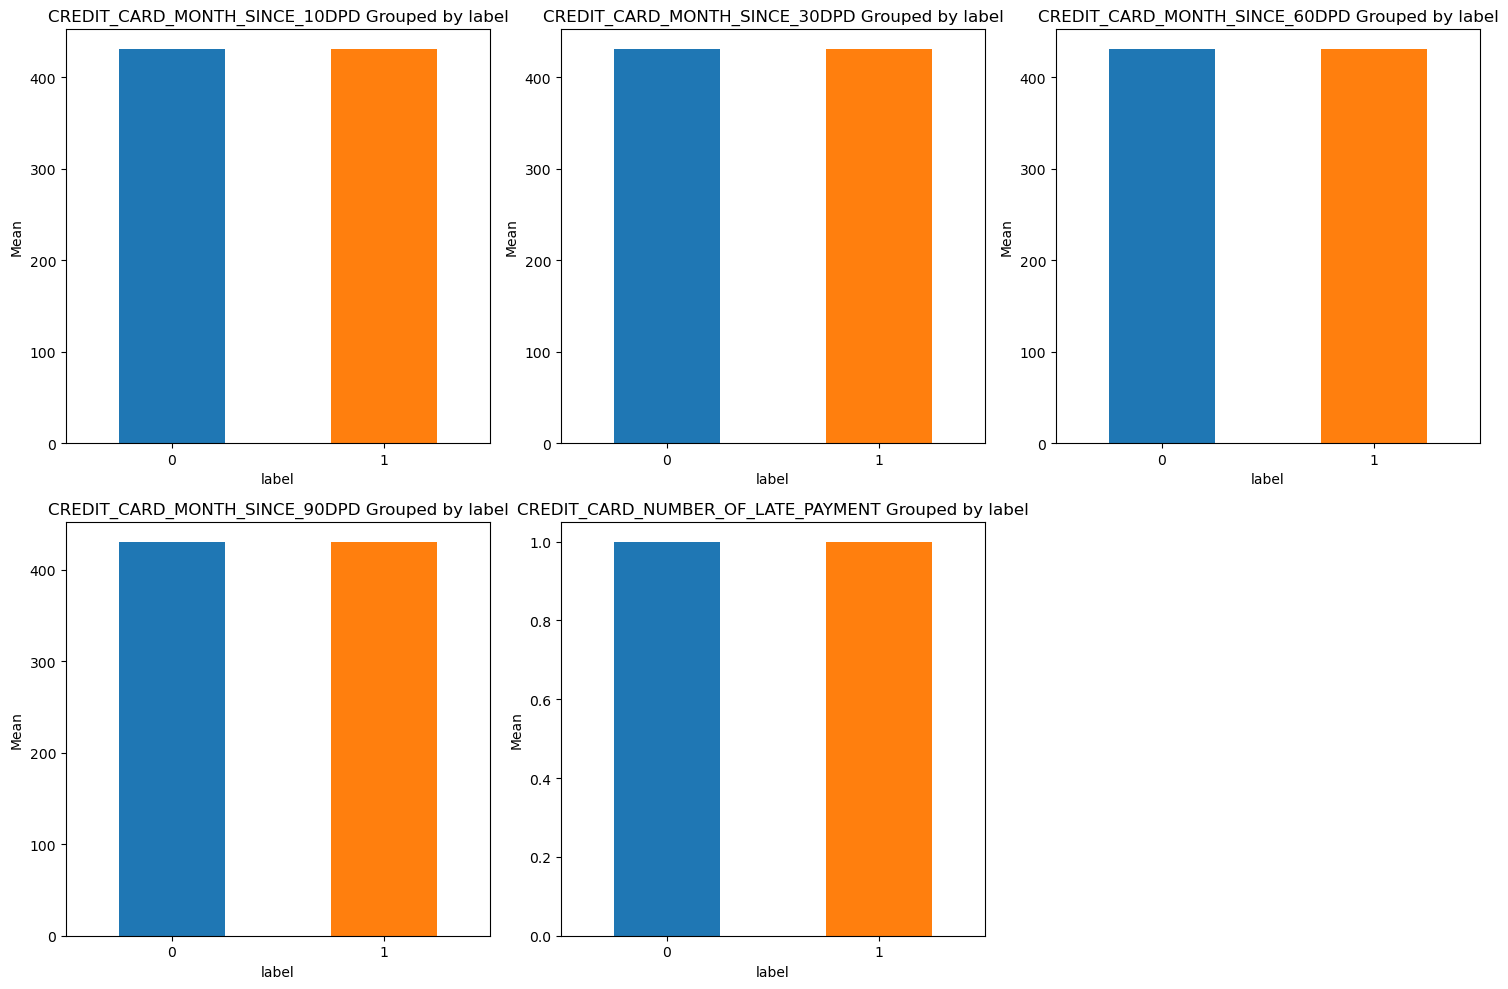

In [ ]:
columns = df.columns[df.columns.str.contains(r'^CREDIT_CARD')]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#ff7f0e'])  # Customize colors if needed
    axes[i].set_title(f'{col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distribution

C:\Users\trong\AppData\Local\Temp\ipykernel_10168\860073492.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df_t.loc[df_t['label'] == 1].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\860073492.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nd = df_t.loc[df_t['label'] == 0].groupby(bin_edges)[col].count()
C:\Users\trong\AppData\Local\Temp\ipykernel_10168\860073492.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

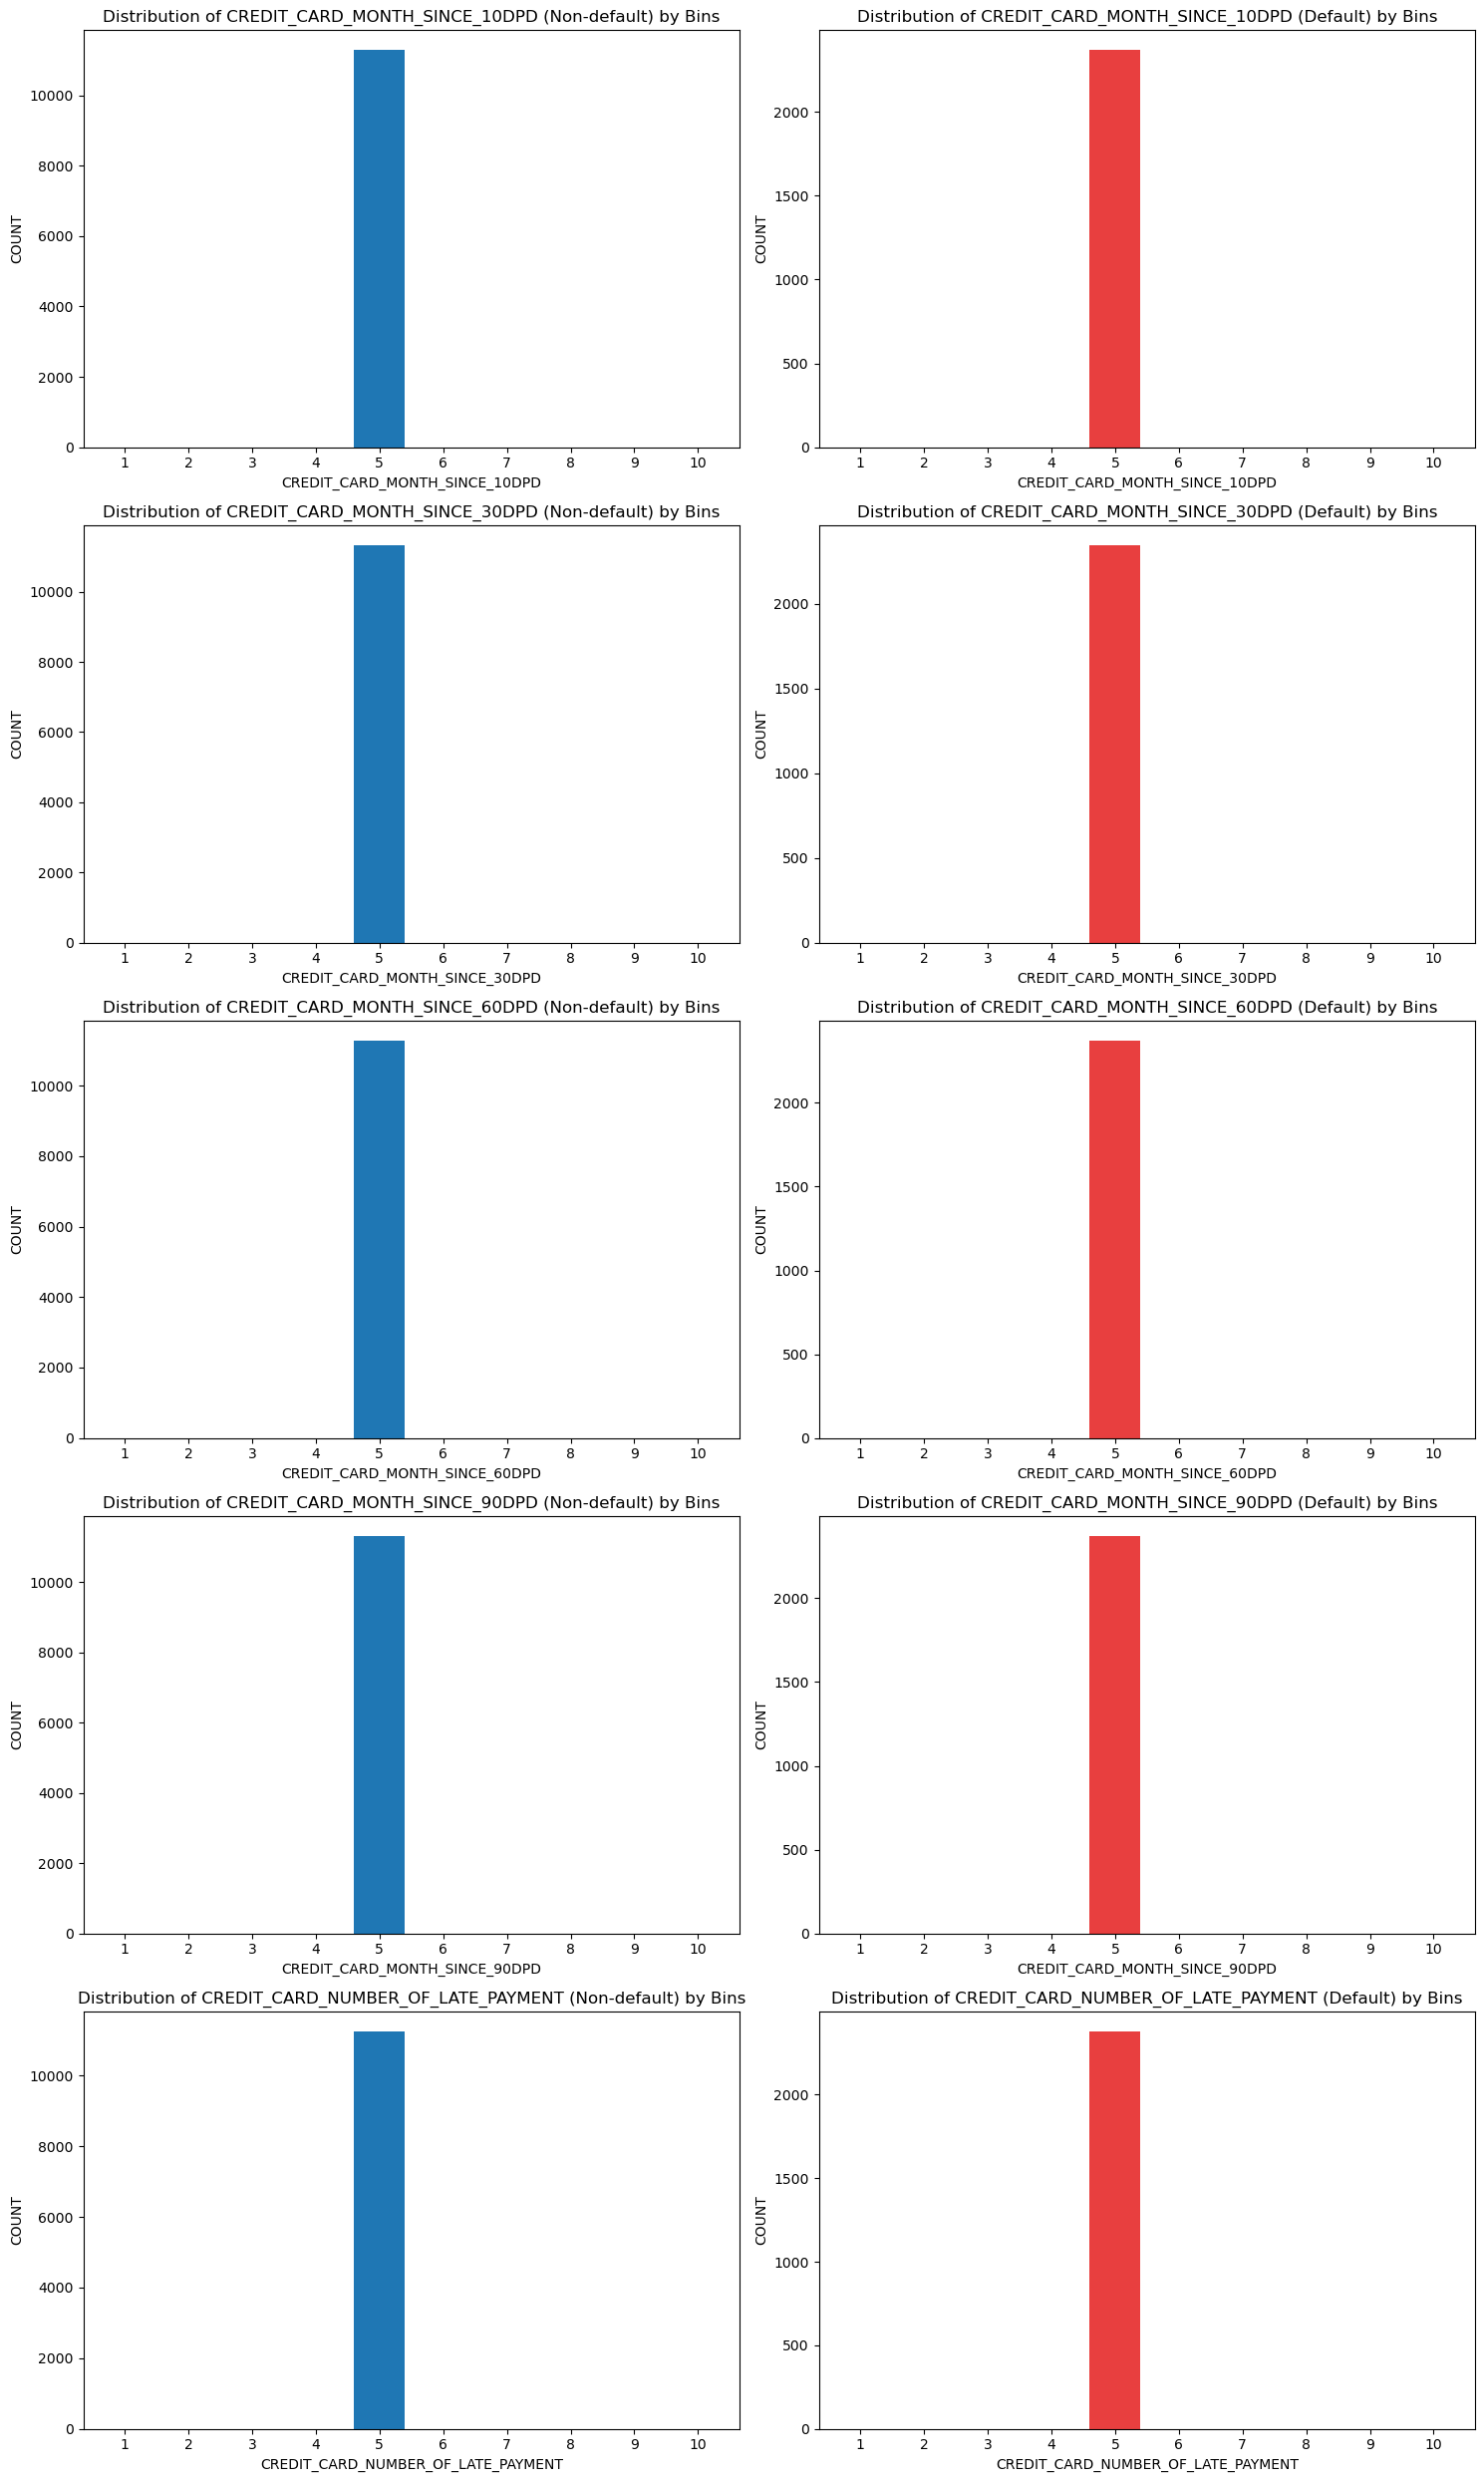

In [ ]:
df_t = df.copy(deep=True)
columns = df_t.columns[df_t.columns.str.contains(r'^CREDIT_CARD')]
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each column and plot the binned data grouped by the binary label
for i, col in enumerate(columns):
    # Define the binning (5 bins)
    bins = 10
    bin_edges = pd.cut(df_t[col], bins=bins, labels=range(1, bins+1))

    # Value counts for defaults and non-defaults, after binning
    d = df_t.loc[df_t['label'] == 1].groupby(bin_edges)[col].count()
    nd = df_t.loc[df_t['label'] == 0].groupby(bin_edges)[col].count()

    # Combine the two Series into a single DataFrame for aligned plotting
    combined_df_t = pd.DataFrame({'Default': d, 'Non-default': nd}).fillna(0)

    # Plot for non-defaults
    combined_df_t['Non-default'].plot(kind='bar', ax=axes[i, 0], color='#1f77b4', width=0.8)
    axes[i, 0].set_title(f'Distribution of {col} (Non-default) by Bins')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('COUNT')
    axes[i, 0].tick_params(axis='x', rotation=0)

    # Plot for defaults
    combined_df_t['Default'].plot(kind='bar', ax=axes[i, 1], color='#E83F3F', width=0.8)
    axes[i, 1].set_title(f'Distribution of {col} (Default) by Bins')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('COUNT')
    axes[i, 1].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Group 6

#### mean

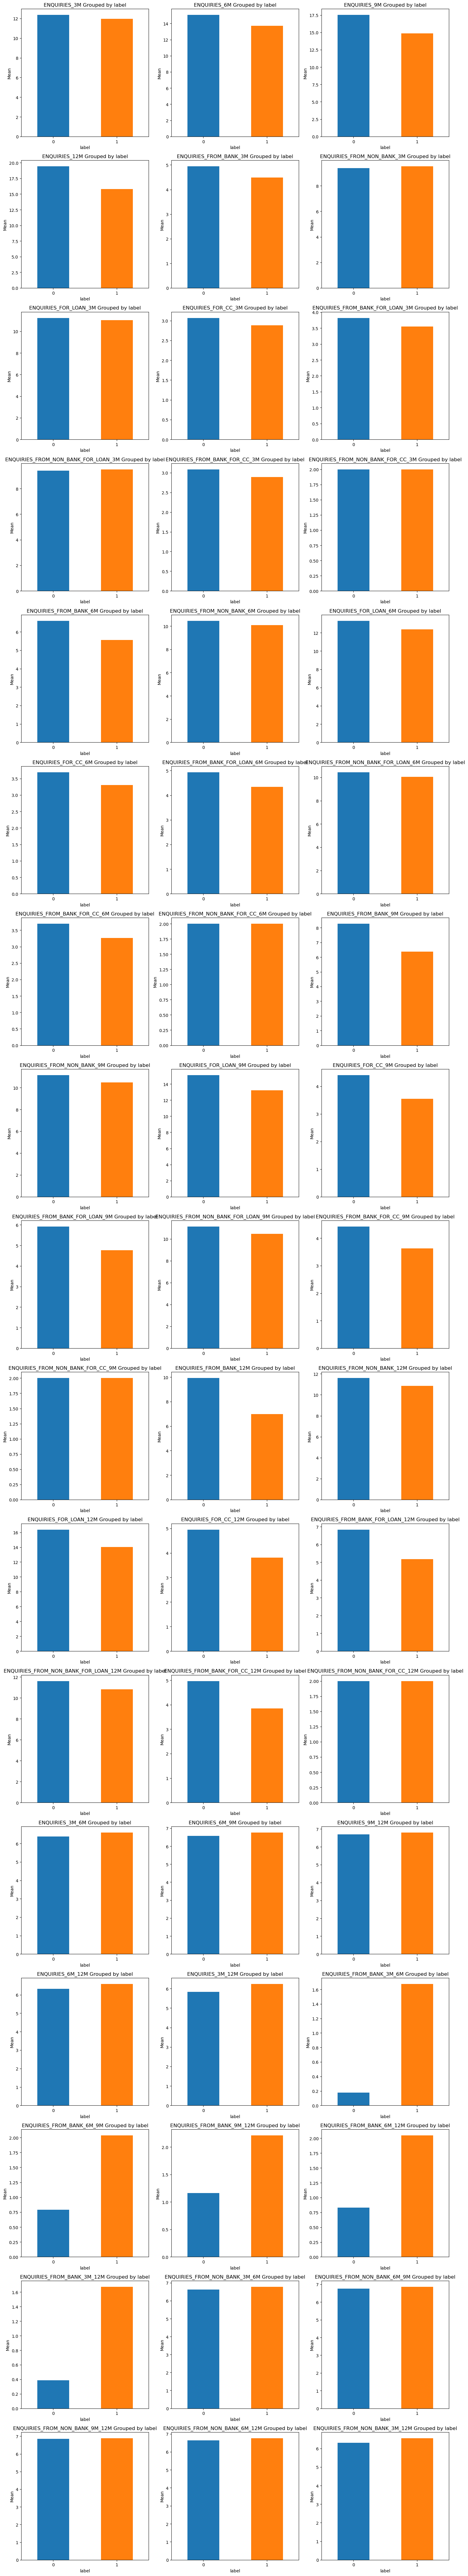

In [ ]:
columns = df.columns[df.columns.str.contains('ENQ')]
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    grouped_means = df.groupby("label")[col].mean()

    # Plot on the corresponding subplot
    grouped_means.plot(kind='bar', ax=axes[i], color=['#1f77b4', '#ff7f0e'])  # Customize colors if needed
    axes[i].set_title(f'{col} Grouped by {"label"}')
    axes[i].set_xlabel("label")
    axes[i].set_ylabel('Mean')
    axes[i].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### distribution

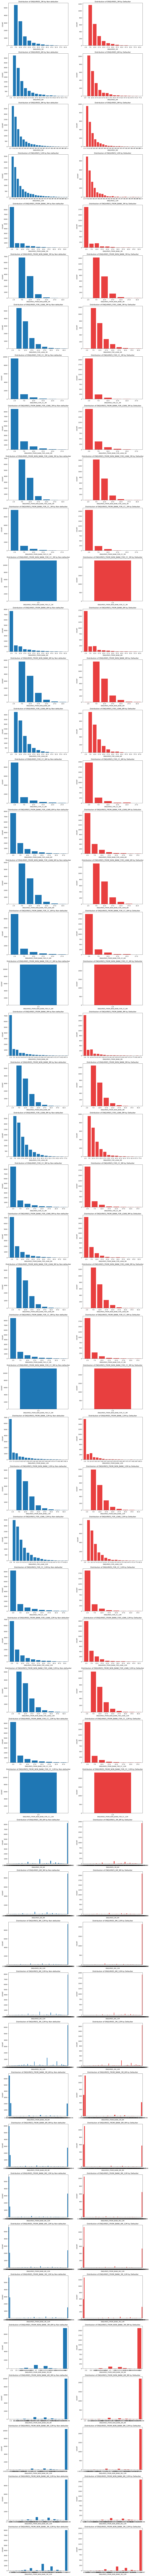

In [ ]:
df_t = df.copy(deep=True)
# df_t = df_t[df_t['SHORT_TERM_COUNT'] >= 4]
columns = df_t.columns[df_t.columns.str.contains('ENQ')]
n_cols = 2
n_rows = len(columns)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
# axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
for i, col in enumerate(columns):
    d = df_t.loc[df_t['label'] == 1, col].value_counts().sort_index()
    nd = df_t.loc[df_t['label'] == 0, col].value_counts().sort_index()

    # Combine the two Series into a single DataFrame for aligned plotting
    combined_df_t = pd.DataFrame({'Default': d, 'Non-default': nd})


    # Plot for non-defaults
    combined_df_t['Non-default'].plot(kind='bar', ax=axes[i, 0], color='#1f77b4', width=0.8)
    axes[i, 0].set_title(f'Distribution of {col} by Non-defaulter')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('COUNT')
    axes[i, 0].tick_params(axis='x', rotation=0)

    # Plot for defaults
    combined_df_t['Default'].plot(kind='bar', ax=axes[i, 1], color='#E83F3F', width=0.8)
    axes[i, 1].set_title(f'Distribution of {col} by Defaulter')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('COUNT')
    axes[i, 1].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid


plt.tight_layout()
plt.show()

# Theories

In [ ]:
df.columns[df.columns.str.contains('COUNT')]

Index(['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT',
       'SHORT_TERM_COUNT_BANK', 'MID_TERM_COUNT_BANK', 'LONG_TERM_COUNT_BANK',
       'SHORT_TERM_COUNT_NON_BANK', 'MID_TERM_COUNT_NON_BANK',
       'LONG_TERM_COUNT_NON_BANK'],
      dtype='object')

#### Mutual Information

In [ ]:
## from sklearn.feature_selection import SelectKBest,mutual_info_classif
## MI model
# mic = SelectKBest(score_func=mutual_info_classif,k=3)
# df_t.dropna(inplace=True)
# X = df_t[df_t.columns.drop('label')]
# y = df_t['label']
# mic.fit(X,y)
# feature_MI_score = pd.Series(mic.scores_,index=X.columns)
# feature_MI_score.sort_values(ascending=False)

### Theories 1 - binary column for cc_month_since - outstanding compare to raw but still low

C:\Users\trong\AppData\Local\Temp\ipykernel_10168\4000130399.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_t[['binary_10DPD', 'binary_30DPD', 'binary_60DPD', 'binary_90DPD']] = df_t.iloc[:, :4].applymap(is_late)


<Axes: >

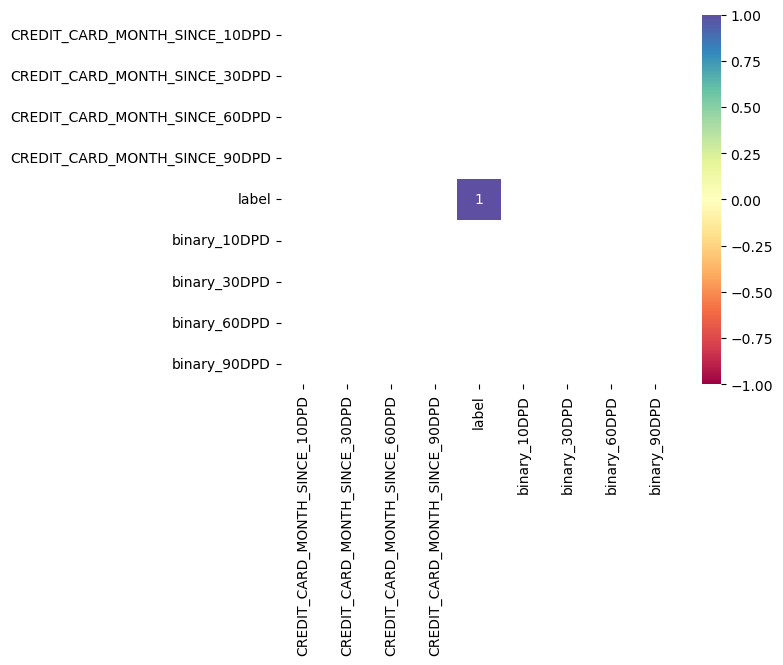

In [ ]:

df_t = df[['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
        'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD', 'label']].copy(deep=True)

def is_late(x):
    if x == 431 or np.isnan(x): return 0
    else: return 1
df_t[['binary_10DPD', 'binary_30DPD', 'binary_60DPD', 'binary_90DPD']] = df_t.iloc[:, :4].applymap(is_late)
sns.heatmap(df_t.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)

MI for above

In [ ]:
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

binary_90DPD                     0.005965
CREDIT_CARD_MONTH_SINCE_30DPD    0.004350
binary_30DPD                     0.001280
CREDIT_CARD_MONTH_SINCE_90DPD    0.000513
CREDIT_CARD_MONTH_SINCE_10DPD    0.000201
CREDIT_CARD_MONTH_SINCE_60DPD    0.000000
binary_10DPD                     0.000000
binary_60DPD                     0.000000
dtype: float64

### Therory 2: Diff in short/mid/long - count - **outstanding**

In [ ]:
df_t = df[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'label']].copy(deep=True)
df_t['MANY_SHORT'] = np.where(df_t['SHORT_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_MID'] = np.where(df_t['MID_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_LONG'] = np.where(df_t['LONG_TERM_COUNT'] >= 4, 1, 0)
df_t['Theory 1'] = df_t.iloc[:, -3:].sum(axis=1)
df_t['Theory 2'] = df_t['MANY_SHORT'] * 10 + df_t['MANY_MID'] * 5 + df_t['MANY_LONG']
df_t['Theory 3'] = (df_t['MANY_SHORT'] * 10 + df_t['MANY_MID'] * 5 + df_t['MANY_LONG']) / 15


df_t.corr()

SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT     label  \
SHORT_TERM_COUNT          1.000000       -0.065714        -0.023876 -0.312538   
MID_TERM_COUNT           -0.065714        1.000000         0.063819 -0.149037   
LONG_TERM_COUNT          -0.023876        0.063819         1.000000 -0.038238   
label                    -0.312538       -0.149037        -0.038238  1.000000   
MANY_SHORT                0.625382       -0.067764        -0.047153 -0.322595   
MANY_MID                 -0.048128        0.790921         0.045000 -0.143955   
MANY_LONG                -0.022270        0.058473         0.984120 -0.035581   
Theory 1                  0.338177        0.568199         0.215071 -0.330174   
Theory 2                  0.511957        0.345754         0.009353 -0.361100   
Theory 3                  0.511957        0.345754         0.009353 -0.361100   

                  MANY_SHORT  MANY_MID  MANY_LONG  Theory 1  Theory 2  \
SHORT_TERM_COUNT    0.625382 -0.048128  -0.022270  0.338177  0.511957   
MID_TERM_COUNT     -0.067764  0.790921   0.058473  0.568199  0.345754   
LONG_TERM_COUNT    -0.047153  0.045000   0.984120  0.215071  0.009353   
label              -0.322595 -0.143955  -0.035581 -0.330174 -0.361100   
MANY_SHORT          1.000000 -0.054312  -0.042822  0.614093  0.861706   
MANY_MID           -0.054312  1.000000   0.042078  0.727634  0.459113   
MANY_LONG          -0.042822  0.042078   1.000000  0.208818  0.010734   
Theory 1            0.614093  0.727634   0.208818  1.000000  0.920943   
Theory 2            0.861706  0.459113   0.010734  0.920943  1.000000   
Theory 3            0.861706  0.459113   0.010734  0.920943  1.000000   

                  Theory 3  
SHORT_TERM_COUNT  0.511957  
MID_TERM_COUNT    0.345754  
LONG_TERM_COUNT   0.009353  
label            -0.361100  
MANY_SHORT        0.861706  
MANY_MID          0.459113  
MANY_LONG         0.010734  
Theory 1          0.920943  
Theory 2          1.000000  
Theory 3          1.000000

In [ ]:
# MI model
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

Theory 2            0.143525
Theory 1            0.139048
Theory 3            0.136347
MANY_SHORT          0.077852
SHORT_TERM_COUNT    0.072001
MANY_MID            0.020968
MID_TERM_COUNT      0.017006
LONG_TERM_COUNT     0.000000
MANY_LONG           0.000000
dtype: float64

### Theory 3: Diff in number of loan - top highest

In [ ]:
df_t = df[['NUMBER_OF_LOANS', 'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'label']].copy(deep=True)
df_t['MANY_LOANS'] = np.where(df_t['NUMBER_OF_LOANS'] >= 4, 1, 0)
df_t['MANY_LOANS_BANK'] = np.where(df_t['NUMBER_OF_LOANS_BANK'] >= 4, 1, 0)
df_t['MANY_LOANS_NON_BANK'] = np.where(df_t['NUMBER_OF_LOANS_NON_BANK'] >= 4, 1, 0)

df_t['Theory 1'] = df_t.iloc[:, -3:].sum(axis=1)

df_t.corr()

NUMBER_OF_LOANS  NUMBER_OF_LOANS_BANK  \
NUMBER_OF_LOANS                  1.000000              0.701023   
NUMBER_OF_LOANS_BANK             0.701023              1.000000   
NUMBER_OF_LOANS_NON_BANK         0.798654              0.130785   
label                           -0.350134             -0.259070   
MANY_LOANS                       0.449074              0.172817   
MANY_LOANS_BANK                  0.462120              0.751441   
MANY_LOANS_NON_BANK              0.382282              0.058227   
Theory 1                         0.602999              0.513713   

                          NUMBER_OF_LOANS_NON_BANK     label  MANY_LOANS  \
NUMBER_OF_LOANS                           0.798654 -0.350134    0.449074   
NUMBER_OF_LOANS_BANK                      0.130785 -0.259070    0.172817   
NUMBER_OF_LOANS_NON_BANK                  1.000000 -0.264508    0.238654   
label                                    -0.264508  1.000000   -0.373840   
MANY_LOANS                                0.238654 -0.373840    1.000000   
MANY_LOANS_BANK                           0.085328 -0.272394    0.209196   
MANY_LOANS_NON_BANK                       0.616418 -0.297617    0.303141   
Theory 1                                  0.423834 -0.459354    0.692270   

                          MANY_LOANS_BANK  MANY_LOANS_NON_BANK  Theory 1  
NUMBER_OF_LOANS                  0.462120             0.382282  0.602999  
NUMBER_OF_LOANS_BANK             0.751441             0.058227  0.513713  
NUMBER_OF_LOANS_NON_BANK         0.085328             0.616418  0.423834  
label                           -0.272394            -0.297617 -0.459354  
MANY_LOANS                       0.209196             0.303141  0.692270  
MANY_LOANS_BANK                  1.000000             0.054736  0.678695  
MANY_LOANS_NON_BANK              0.054736             1.000000  0.654691  
Theory 1                         0.678695             0.654691  1.000000

In [ ]:
# MI model
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

Theory 1                    0.150475
NUMBER_OF_LOANS             0.150429
MANY_LOANS                  0.140619
MANY_LOANS_NON_BANK         0.059667
NUMBER_OF_LOANS_NON_BANK    0.058054
MANY_LOANS_BANK             0.051735
NUMBER_OF_LOANS_BANK        0.043054
dtype: float64

### Theory 4: Diff in number of relationship - top highest

In [ ]:
df_t = df[['NUMBER_OF_RELATIONSHIP', 'NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK', 'label']].copy(deep=True)
# df_t.median()
df_t['MANY_RELATIONSHIP'] = np.where(df_t['NUMBER_OF_RELATIONSHIP'] >= 7, 1, 0)
df_t['MANY_RELATIONSHIP_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_BANK'] >= 7, 1, 0)
df_t['MANY_RELATIONSHIP_NON_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_NON_BANK'] >= 7, 1, 0)

df_t['Theory 1'] = df_t.iloc[:, -3:].sum(axis=1)
df_t['Theory 2'] = df_t['MANY_RELATIONSHIP'] * 5 + df_t['MANY_RELATIONSHIP_BANK'] + df_t['MANY_RELATIONSHIP_NON_BANK']
df_t['Theory 3'] = (df_t['MANY_RELATIONSHIP'] * 5 + df_t['MANY_RELATIONSHIP_BANK'] + df_t['MANY_RELATIONSHIP_NON_BANK']) / 7


df_t.corr()

NUMBER_OF_RELATIONSHIP  \
NUMBER_OF_RELATIONSHIP                         1.000000   
NUMBER_OF_RELATIONSHIP_BANK                    0.860957   
NUMBER_OF_RELATIONSHIP_NON_BANK                0.631505   
label                                         -0.332823   
MANY_RELATIONSHIP                              0.513093   
MANY_RELATIONSHIP_BANK                         0.557268   
MANY_RELATIONSHIP_NON_BANK                     0.439589   
Theory 1                                       0.697069   
Theory 2                                       0.621068   
Theory 3                                       0.621068   

                                 NUMBER_OF_RELATIONSHIP_BANK  \
NUMBER_OF_RELATIONSHIP                              0.860957   
NUMBER_OF_RELATIONSHIP_BANK                         1.000000   
NUMBER_OF_RELATIONSHIP_NON_BANK                     0.147834   
label                                              -0.260890   
MANY_RELATIONSHIP                                   0.275445   
MANY_RELATIONSHIP_BANK                              0.703068   
MANY_RELATIONSHIP_NON_BANK                          0.104495   
Theory 1                                            0.520397   
Theory 2                                            0.389227   
Theory 3                                            0.389227   

                                 NUMBER_OF_RELATIONSHIP_NON_BANK     label  \
NUMBER_OF_RELATIONSHIP                                  0.631505 -0.332823   
NUMBER_OF_RELATIONSHIP_BANK                             0.147834 -0.260890   
NUMBER_OF_RELATIONSHIP_NON_BANK                         1.000000 -0.246642   
label                                                  -0.246642  1.000000   
MANY_RELATIONSHIP                                       0.348218 -0.347442   
MANY_RELATIONSHIP_BANK                                  0.111720 -0.250912   
MANY_RELATIONSHIP_NON_BANK                              0.779934 -0.194175   
Theory 1                                                0.592528 -0.373662   
Theory 2                                                0.465564 -0.380596   
Theory 3                                                0.465564 -0.380596   

                                 MANY_RELATIONSHIP  MANY_RELATIONSHIP_BANK  \
NUMBER_OF_RELATIONSHIP                    0.513093                0.557268   
NUMBER_OF_RELATIONSHIP_BANK               0.275445                0.703068   
NUMBER_OF_RELATIONSHIP_NON_BANK           0.348218                0.111720   
label                                    -0.347442               -0.250912   
MANY_RELATIONSHIP                         1.000000                0.287801   
MANY_RELATIONSHIP_BANK                    0.287801                1.000000   
MANY_RELATIONSHIP_NON_BANK                0.329976                0.077698   
Theory 1                                  0.742121                0.664347   
Theory 2                                  0.965004                0.454087   
Theory 3                                  0.965004                0.454087   

                                 MANY_RELATIONSHIP_NON_BANK  Theory 1  \
NUMBER_OF_RELATIONSHIP                             0.439589  0.697069   
NUMBER_OF_RELATIONSHIP_BANK                        0.104495  0.520397   
NUMBER_OF_RELATIONSHIP_NON_BANK                    0.779934  0.592528   
label                                             -0.194175 -0.373662   
MANY_RELATIONSHIP                                  0.329976  0.742121   
MANY_RELATIONSHIP_BANK                             0.077698  0.664347   
MANY_RELATIONSHIP_NON_BANK                         1.000000  0.686784   
Theory 1                                           0.686784  1.000000   
Theory 2                                           0.491319  0.891918   
Theory 3                                           0.491319  0.891918   

                                 Theory 2  Theory 3  
NUMBER_OF_RELATIONSHIP           0.621068  0.621068  
NUMBER_OF_RELATIONSHIP_BANK      0.389227  0.389

In [ ]:
# MI model
mic = SelectKBest(score_func=mutual_info_classif)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

c:\Users\trong\anaconda3\envs\pydata-book\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


NUMBER_OF_RELATIONSHIP             0.134403
Theory 2                           0.094761
Theory 3                           0.093932
Theory 1                           0.093176
MANY_RELATIONSHIP                  0.087610
NUMBER_OF_RELATIONSHIP_BANK        0.067528
NUMBER_OF_RELATIONSHIP_NON_BANK    0.060727
MANY_RELATIONSHIP_BANK             0.049329
MANY_RELATIONSHIP_NON_BANK         0.024647
dtype: float64

### Theory 5: Diff in number of new_loan - top highest

In [ ]:
cols = ['NUMBER_OF_LOANS','NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
       'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M',
       'NUM_NEW_LOAN_TAKEN_BANK_3M', 'NUM_NEW_LOAN_TAKEN_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_BANK_9M', 'NUM_NEW_LOAN_TAKEN_BANK_12M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_3M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_9M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_12M', 'label']
# cols = ['NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
#        'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M', 'label']
df_t = df[cols].copy(deep=True)
df_t['SUM_NEW'] = df_t[['NUM_NEW_LOAN_TAKEN_3M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_12M']].sum(axis=1)
df_t[['SUM_NEW', 'NUMBER_OF_LOANS']]
df_t['MANY_NEW_LOAN_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_NON_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_12M'] >= 4, 1, 0)

df_t['Theory 1'] = df_t.iloc[:, -12:].sum(axis=1)
df_t['Theory 2'] = df_t['MANY_NEW_LOAN_3M'] * 5 + df_t['MANY_NEW_LOAN_BANK_3M'] + df_t['MANY_NEW_LOAN_NON_BANK_3M']
df_t['Theory 3'] = (df_t['MANY_NEW_LOAN_3M'] * 5 + df_t['MANY_NEW_LOAN_BANK_3M'] + df_t['MANY_NEW_LOAN_NON_BANK_3M']) / 7


df_t.corr()

NUMBER_OF_LOANS  NUM_NEW_LOAN_TAKEN_3M  \
NUMBER_OF_LOANS                         1.000000               0.465349   
NUM_NEW_LOAN_TAKEN_3M                   0.465349               1.000000   
NUM_NEW_LOAN_TAKEN_6M                   0.638653               0.772246   
NUM_NEW_LOAN_TAKEN_9M                   0.751565               0.687797   
NUM_NEW_LOAN_TAKEN_12M                  0.809026               0.632853   
NUM_NEW_LOAN_TAKEN_BANK_3M              0.463708               1.000000   
NUM_NEW_LOAN_TAKEN_BANK_6M              0.637692               0.772482   
NUM_NEW_LOAN_TAKEN_BANK_9M              0.750791               0.688625   
NUM_NEW_LOAN_TAKEN_BANK_12M             0.808332               0.630358   
NUM_NEW_LOAN_TAKEN_NON_BANK_3M          0.463867               1.000000   
NUM_NEW_LOAN_TAKEN_NON_BANK_6M          0.638323               0.772989   
NUM_NEW_LOAN_TAKEN_NON_BANK_9M          0.747867               0.687201   
NUM_NEW_LOAN_TAKEN_NON_BANK_12M         0.809346               0.632928   
label                                  -0.350134              -0.172833   
SUM_NEW                                 0.703330               0.781923   
MANY_NEW_LOAN_3M                       -0.005409                    NaN   
MANY_NEW_LOAN_6M                        0.350027               0.411986   
MANY_NEW_LOAN_9M                        0.335352               0.323195   
MANY_NEW_LOAN_12M                       0.316486               0.276093   
MANY_NEW_LOAN_BANK_3M                  -0.000600              -0.010097   
MANY_NEW_LOAN_BANK_6M                   0.351579               0.417226   
MANY_NEW_LOAN_BANK_9M                   0.334234               0.326247   
MANY_NEW_LOAN_BANK_12M                  0.307979               0.272698   
MANY_NEW_LOAN_NON_BANK_3M              -0.002145               0.005002   
MANY_NEW_LOAN_NON_BANK_6M               0.357896               0.419540   
MANY_NEW_LOAN_NON_BANK_9M               0.330889               0.329963   
MANY_NEW_LOAN_NON_BANK_12M              0.314884               0.283675   
Theory 1                                0.430570               0.443989   
Theory 2                               -0.005748              -0.003617   
Theory 3                               -0.005748              -0.003617   

                                 NUM_NEW_LOAN_TAKEN_6M  NUM_NEW_LOAN_TAKEN_9M  \
NUMBER_OF_LOANS                               0.638653               0.751565   
NUM_NEW_LOAN_TAKEN_3M                         0.772246               0.687797   
NUM_NEW_LOAN_TAKEN_6M                         1.000000               0.888470   
NUM_NEW_LOAN_TAKEN_9M                         0.888470               1.000000   
NUM_NEW_LOAN_TAKEN_12M                        0.829441               0.942335   
NUM_NEW_LOAN_TAKEN_BANK_3M                    0.772510               0.686240   
NUM_NEW_LOAN_TAKEN_BANK_6M                    1.000000               0.887746   
NUM_NEW_LOAN_TAKEN_BANK_9M                    0.887620               1.000000   
NUM_NEW_LOAN_TAKEN_BANK_12M                   0.825821               0.941560   
NUM_NEW_LOAN_TAKEN_NON_BANK_3M                0.773782               0.684220   
NUM_NEW_LOAN_TAKEN_NON_BANK_6M                1.000000               0.889153   
NUM_NEW_LOAN_TAKEN_NON_BANK_9M                0.887935               1.000000   
NUM_NEW_LOAN_TAKEN_NON_BANK_12M               0.826766               0.941747   
label                                        -0.255318              -0.304447   
SUM_NEW                                       0.913135               0.937024   
MANY_NEW_LOAN_3M                             -0.011480              -0.014050   
MANY_NEW_LOAN_6M                              0.665865               0.496724   
MANY_NEW_LOAN_9M                              0.426179               0.601476   
MANY_NEW_LOAN_12M                             0.370417               0.405636   
MANY_NEW_LOAN_BANK_3M                        -0.005052               0.005367   
MANY_N

In [ ]:
# MI model
mic = SelectKBest(score_func=mutual_info_classif)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

NUMBER_OF_LOANS                    0.136490
NUM_NEW_LOAN_TAKEN_BANK_12M        0.098083
SUM_NEW                            0.094998
MANY_NEW_LOAN_12M                  0.092867
MANY_NEW_LOAN_NON_BANK_12M         0.088251
NUM_NEW_LOAN_TAKEN_12M             0.085715
MANY_NEW_LOAN_BANK_12M             0.084511
Theory 1                           0.081919
NUM_NEW_LOAN_TAKEN_NON_BANK_12M    0.077761
NUM_NEW_LOAN_TAKEN_9M              0.077415
NUM_NEW_LOAN_TAKEN_BANK_9M         0.075799
MANY_NEW_LOAN_NON_BANK_9M          0.074274
MANY_NEW_LOAN_9M                   0.074224
NUM_NEW_LOAN_TAKEN_NON_BANK_9M     0.073124
MANY_NEW_LOAN_BANK_9M              0.061824
NUM_NEW_LOAN_TAKEN_BANK_6M         0.056513
MANY_NEW_LOAN_BANK_6M              0.051628
MANY_NEW_LOAN_NON_BANK_6M          0.045108
NUM_NEW_LOAN_TAKEN_6M              0.044686
NUM_NEW_LOAN_TAKEN_NON_BANK_6M     0.040717
MANY_NEW_LOAN_6M                   0.038840
NUM_NEW_LOAN_TAKEN_BANK_3M         0.018262
NUM_NEW_LOAN_TAKEN_NON_BANK_3M  

### Theory 6: Ratio by loans - top highest

In [ ]:
cols = ['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT',
        'NUMBER_OF_LOANS', 'label']
df_t = df[cols].copy(deep=True)
df_t['NUMBER_OF_LOANS'].fillna(df_t['NUMBER_OF_LOANS'].mean(), inplace=True)
df_t[['RATIO_SHORT', 'RATIO_MID', 'RATIO_LONG']] = \
df_t[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].div(df_t['NUMBER_OF_LOANS'], axis=0)
df_t.corr()

C:\Users\trong\AppData\Local\Temp\ipykernel_8856\3208166248.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_t['NUMBER_OF_LOANS'].fillna(df_t['NUMBER_OF_LOANS'].mean(), inplace=True)


SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
SHORT_TERM_COUNT          1.000000       -0.065714        -0.023876   
MID_TERM_COUNT           -0.065714        1.000000         0.063819   
LONG_TERM_COUNT          -0.023876        0.063819         1.000000   
NUMBER_OF_LOANS           0.686375        0.593602         0.108527   
label                    -0.312538       -0.149037        -0.038238   
RATIO_SHORT               0.428219       -0.707253        -0.149851   
RATIO_MID                -0.616677        0.569383        -0.016635   
RATIO_LONG               -0.515173       -0.303949         0.145699   

                  NUMBER_OF_LOANS     label  RATIO_SHORT  RATIO_MID  \
SHORT_TERM_COUNT         0.686375 -0.312538     0.428219  -0.616677   
MID_TERM_COUNT           0.593602 -0.149037    -0.707253   0.569383   
LONG_TERM_COUNT          0.108527 -0.038238    -0.149851  -0.016635   
NUMBER_OF_LOANS          1.000000 -0.332811    -0.285377  -0.186646   
label                   -0.332811  1.000000     0.060419   0.284405   
RATIO_SHORT             -0.285377  0.060419     1.000000  -0.564064   
RATIO_MID               -0.186646  0.284405    -0.564064   1.000000   
RATIO_LONG              -0.623296  0.555102     0.218325   0.455148   

                  RATIO_LONG  
SHORT_TERM_COUNT   -0.515173  
MID_TERM_COUNT     -0.303949  
LONG_TERM_COUNT     0.145699  
NUMBER_OF_LOANS    -0.623296  
label               0.555102  
RATIO_SHORT         0.218325  
RATIO_MID           0.455148  
RATIO_LONG          1.000000

In [ ]:
# from sklearn.feature_selection import SelectKBest,mutual_info_classif
# MI model
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

RATIO_LONG          0.129100
NUMBER_OF_LOANS     0.125342
SHORT_TERM_COUNT    0.073358
RATIO_MID           0.070635
RATIO_SHORT         0.019211
MID_TERM_COUNT      0.011377
LONG_TERM_COUNT     0.005076
dtype: float64

### Theory 7: Change in equiries - low

In [ ]:
nega_cols = ['ENQUIRIES_FROM_BANK_3M_6M','ENQUIRIES_FROM_BANK_6M_9M','ENQUIRIES_FROM_BANK_9M_12M','ENQUIRIES_FROM_BANK_6M_12M','ENQUIRIES_FROM_BANK_3M_12M', 'label']
df_t = df[nega_cols].copy(deep=True)
df_t['ENQ_UP_3M_6M'] = np.where(df_t['ENQUIRIES_FROM_BANK_3M_6M'] >= 0, 1, -1)
df_t['ENQ_UP_6M_9M'] = np.where(df_t['ENQUIRIES_FROM_BANK_6M_9M'] >= 0, 1, -1)
df_t['ENQ_UP_9M_12M'] = np.where(df_t['ENQUIRIES_FROM_BANK_9M_12M'] >= 0, 1, -1)
df_t['ENQ_UP_6M_12M'] = np.where(df_t['ENQUIRIES_FROM_BANK_6M_12M'] >= 0, 1, -1)
df_t['ENQ_UP_3M_12M'] = np.where(df_t['ENQUIRIES_FROM_BANK_3M_12M'] >= 0, 1, -1)
df_t.corr()

ENQUIRIES_FROM_BANK_3M_6M  \
ENQUIRIES_FROM_BANK_3M_6M                    1.000000   
ENQUIRIES_FROM_BANK_6M_9M                    0.910491   
ENQUIRIES_FROM_BANK_9M_12M                   0.825607   
ENQUIRIES_FROM_BANK_6M_12M                   0.881534   
ENQUIRIES_FROM_BANK_3M_12M                   0.916819   
label                                        0.117766   
ENQ_UP_3M_6M                                 0.906245   
ENQ_UP_6M_9M                                 0.740525   
ENQ_UP_9M_12M                                0.681545   
ENQ_UP_6M_12M                                0.683449   
ENQ_UP_3M_12M                                0.678457   

                            ENQUIRIES_FROM_BANK_6M_9M  \
ENQUIRIES_FROM_BANK_3M_6M                    0.910491   
ENQUIRIES_FROM_BANK_6M_9M                    1.000000   
ENQUIRIES_FROM_BANK_9M_12M                   0.934652   
ENQUIRIES_FROM_BANK_6M_12M                   0.966766   
ENQUIRIES_FROM_BANK_3M_12M                   0.915747   
label                                        0.083863   
ENQ_UP_3M_6M                                 0.801708   
ENQ_UP_6M_9M                                 0.910134   
ENQ_UP_9M_12M                                0.748591   
ENQ_UP_6M_12M                                0.749014   
ENQ_UP_3M_12M                                0.745559   

                            ENQUIRIES_FROM_BANK_9M_12M  \
ENQUIRIES_FROM_BANK_3M_6M                     0.825607   
ENQUIRIES_FROM_BANK_6M_9M                     0.934652   
ENQUIRIES_FROM_BANK_9M_12M                    1.000000   
ENQUIRIES_FROM_BANK_6M_12M                    0.962844   
ENQUIRIES_FROM_BANK_3M_12M                    0.924953   
label                                         0.060069   
ENQ_UP_3M_6M                                  0.725349   
ENQ_UP_6M_9M                                  0.807222   
ENQ_UP_9M_12M                                 0.914873   
ENQ_UP_6M_12M                                 0.809164   
ENQ_UP_3M_12M                                 0.801546   

                            ENQUIRIES_FROM_BANK_6M_12M  \
ENQUIRIES_FROM_BANK_3M_6M                     0.881534   
ENQUIRIES_FROM_BANK_6M_9M                     0.966766   
ENQUIRIES_FROM_BANK_9M_12M                    0.962844   
ENQUIRIES_FROM_BANK_6M_12M                    1.000000   
ENQUIRIES_FROM_BANK_3M_12M                    0.953289   
label                                         0.087352   
ENQ_UP_3M_6M                                  0.772326   
ENQ_UP_6M_9M                                  0.783118   
ENQ_UP_9M_12M                                 0.790750   
ENQ_UP_6M_12M                                 0.899102   
ENQ_UP_3M_12M                                 0.785914   

                            ENQUIRIES_FROM_BANK_3M_12M     label  \
ENQUIRIES_FROM_BANK_3M_6M                     0.916819  0.117766   
ENQUIRIES_FROM_BANK_6M_9M                     0.915747  0.083863   
ENQUIRIES_FROM_BANK_9M_12M                    0.924953  0.060069   
ENQUIRIES_FROM_BANK_6M_12M                    0.953289  0.087352   
ENQUIRIES_FROM_BANK_3M_12M                    1.000000  0.111745   
label                                         0.111745  1.000000   
ENQ_UP_3M_6M                                  0.749882  0.195945   
ENQ_UP_6M_9M                                  0.774042  0.165375   
ENQ_UP_9M_12M                                 0.786748  0.149093   
ENQ_UP_6M_12M                                 0.791937  0.159285   
ENQ_UP_3M_12M                                 0.895515  0.154778   

                            ENQ_UP_3M_6M  ENQ_UP_6M_9M  ENQ_UP_9M_12M  \
ENQUIRIES_FROM_BANK_3M_6M       0.906245      0.740525       0.681545   
ENQUIRIES_FROM_BANK_6M_9M       0.801708      0.910134       0.748591   
ENQUIRIES_FROM_BANK_9M_12M      0.725349      0.807222       0.914873   
ENQUIRIES_FROM_BANK_6M_12M      0.772326      0.783118       0.790750   
ENQUIRIES_FROM_BANK_3M_12M      0.749882      0.774042       0.786748   
label    

In [ ]:
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

ENQUIRIES_FROM_BANK_9M_12M    0.052832
ENQUIRIES_FROM_BANK_6M_9M     0.048826
ENQUIRIES_FROM_BANK_3M_6M     0.047466
ENQUIRIES_FROM_BANK_6M_12M    0.037251
ENQUIRIES_FROM_BANK_3M_12M    0.028706
ENQ_UP_6M_9M                  0.027347
ENQ_UP_3M_6M                  0.026304
ENQ_UP_9M_12M                 0.022986
ENQ_UP_3M_12M                 0.017344
ENQ_UP_6M_12M                 0.013157
dtype: float64

# Nháp

In [ ]:
df.columns[df.columns.str.contains('RE')]

Index(['NUMBER_OF_RELATIONSHIP', 'NUMBER_OF_RELATIONSHIP_BANK',
       'NUMBER_OF_RELATIONSHIP_NON_BANK'],
      dtype='object')

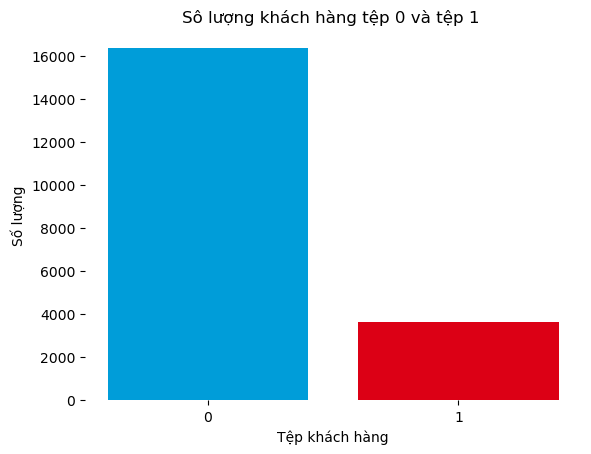

In [ ]:
fig, ax = plt.subplots(1, 1)
df_t = df.groupby('label', as_index=False).size()


# Plot the sum of the two columns

# Hide spines
ax.bar(df_t['label'], df_t['size'], color=['#009dd9', '#dc0015'])  # Change colors as desired

# Change x-axis labels
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set labels and title (optional)
ax.set_xticks([0, 1], ['0', '1'])
ax.set_xlabel('Tệp khách hàng')
ax.set_ylabel('Số lượng')
ax.set_title('Sô lượng khách hàng tệp 0 và tệp 1 ')

# Show the plot
plt.show()

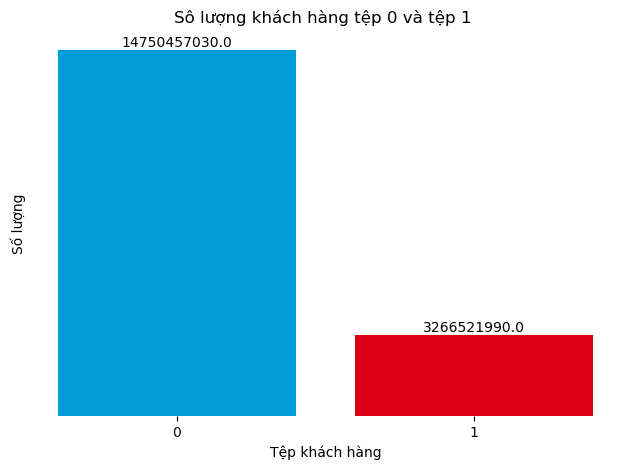

In [ ]:
fig, ax = plt.subplots(1, 1)
df_t = df.groupby('label', as_index=False)['OUTSTANDING_BAL_ALL_CURRENT'].sum()

# Plot the sum of the two columns
ax.bar(df_t['label'], df_t['OUTSTANDING_BAL_ALL_CURRENT'], color=['#009dd9', '#dc0015'])  # Change colors as desired

# Change x-axis labels
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels and title (optional)
ax.set_xticks([0, 1])  # Set the x-ticks for the labels
ax.set_xticklabels(['0', '1'])  # Use set_xticklabels to label the ticks
ax.set_xlabel('Tệp khách hàng')
ax.set_ylabel('Số lượng')
ax.set_title('Sô lượng khách hàng tệp 0 và tệp 1 ')

# Add counts above the bars
for i, count in enumerate(df_t['OUTSTANDING_BAL_ALL_CURRENT']):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')  # Adjust the vertical position as needed

# Hide y-ticks
ax.set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()


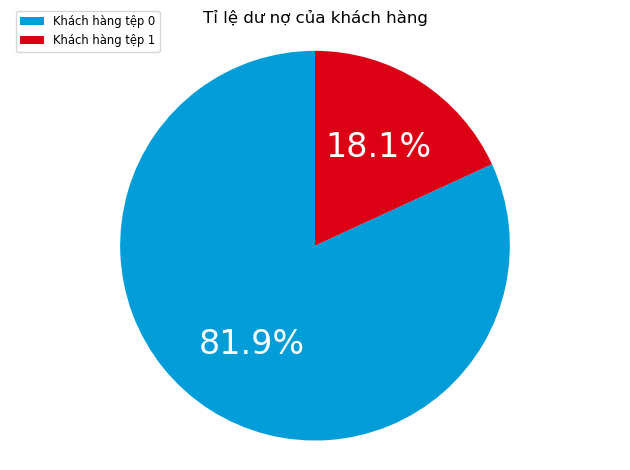

In [ ]:
fig, ax = plt.subplots(1, 1)

# Group by 'label' and sum 'OUTSTANDING_BAL_ALL_CURRENT'
df_t = df.groupby('label', as_index=False)['OUTSTANDING_BAL_ALL_CURRENT'].sum()

# Create a pie chart with a 90-degree start angle
ax.pie(df_t['OUTSTANDING_BAL_ALL_CURRENT'], autopct=lambda p: f'{p:.1f}%', colors=['#009dd9', '#dc0015'], startangle=90, textprops={'color': 'white', 'fontsize': 24})  # Adjust fontsize as needed

# Set the title (optional)
ax.set_title('Tỉ lệ dư nợ của khách hàng')

# Equal aspect ratio ensures the pie chart is a circle
ax.axis('equal')

# Add a legend with custom labels, adjust location and title if needed
labels = ['Khách hàng tệp 0', 'Khách hàng tệp 1']  # Replace with your desired labels
ax.legend(labels, loc='center left', bbox_to_anchor=(0, 1), fontsize='small')

# Show the plot
plt.tight_layout()
plt.show()


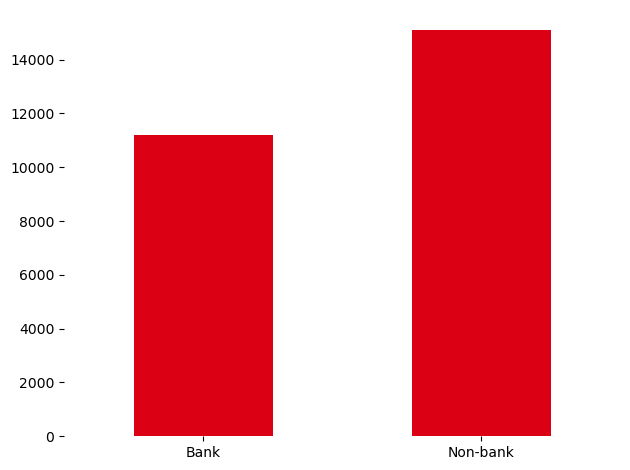

In [ ]:
import matplotlib.pyplot as plt

col = ['NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK']
df_t = df.loc[df['label'] == 1, col]

fig, ax = plt.subplots(1, 1)

# Plot the sum of the two columns
df_t.sum().plot(kind='bar', color='#dc0015', ax=ax)

# Hide spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)  # Correct the second 'top' spine line

# Set custom x-axis labels
ax.set_xticklabels(['Bank', 'Non-bank'], rotation=0)  # Use set_xticklabels and specify the labels

plt.tight_layout()
plt.show()


TypeError: only length-1 arrays can be converted to Python scalars

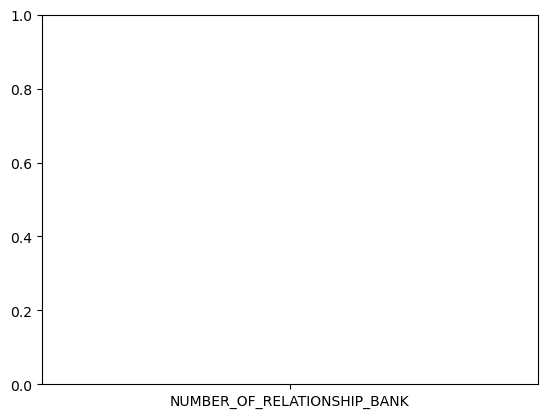

In [ ]:
col = ['NUMBER_OF_RELATIONSHIP_BANK',
       'NUMBER_OF_RELATIONSHIP_NON_BANK']
plt.bar(df.loc[df['label'] == 1, col].T.index, df.loc[df['label'] == 1, col])

for i in range(len(axes)):
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

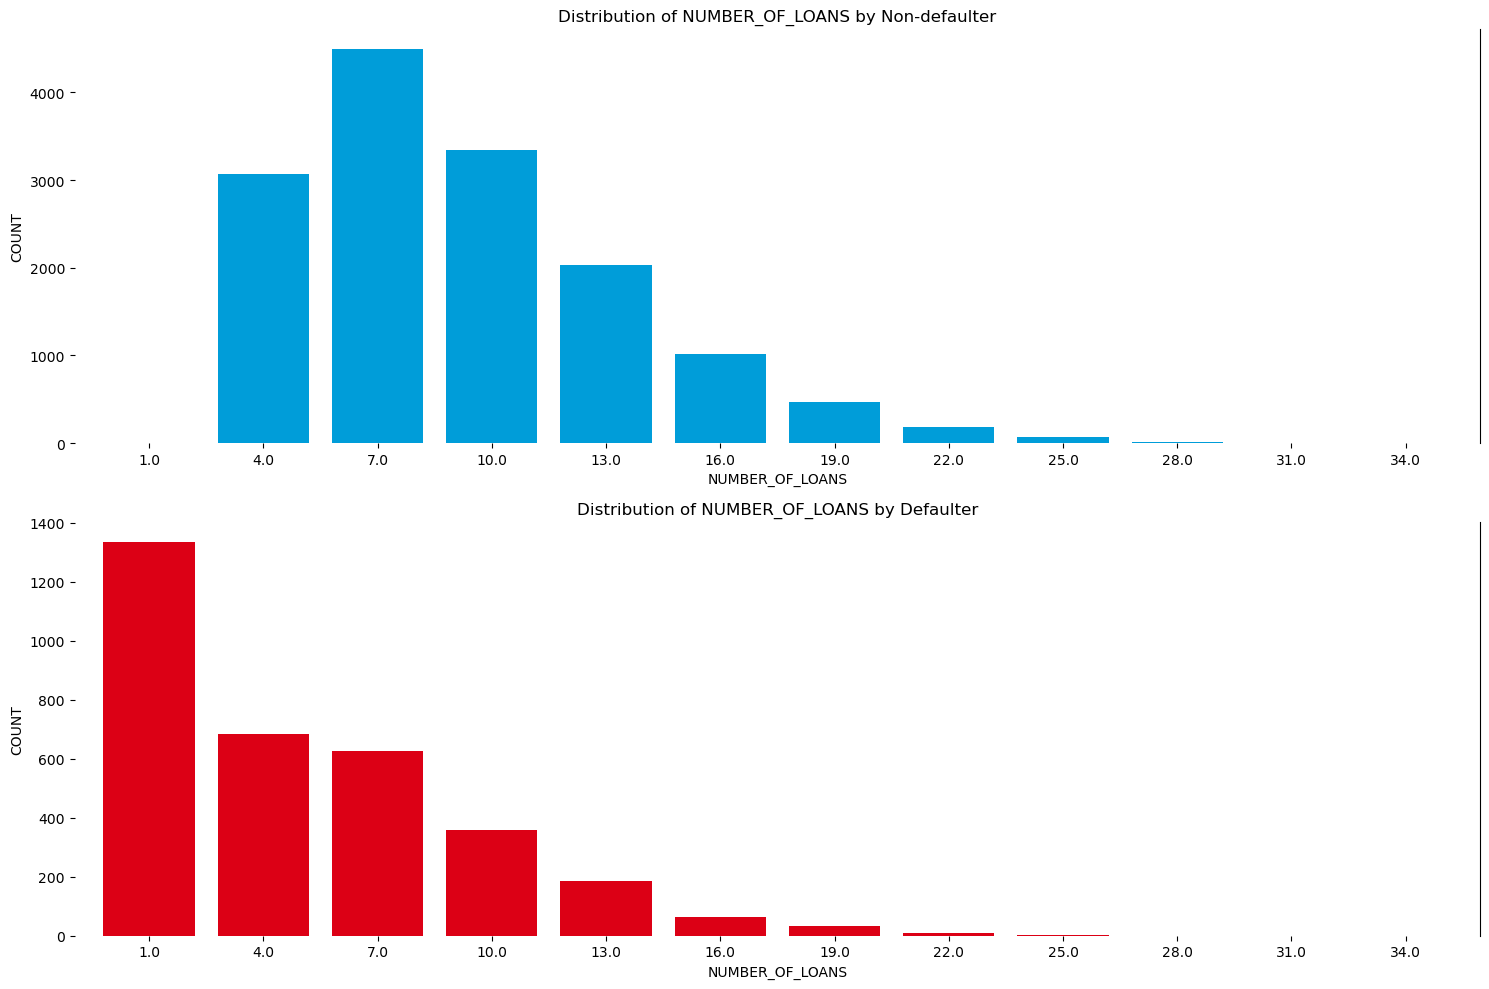

In [ ]:
col = 'NUMBER_OF_LOANS'
d = df.loc[df['label'] == 1, col].value_counts().sort_index()
nd = df.loc[df['label'] == 0, col].value_counts().sort_index()

# Combine the two Series into a single DataFrame for aligned plotting
combined_df = pd.DataFrame({'Default': d, 'Non-default': nd})
# combined_df = combined_d.astype(int)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# Plot for non-defaults
combined_df['Non-default'].plot(kind='bar', ax=axes[0], color='#009dd9', width=0.8)
axes[0].set_title(f'Distribution of {col} by Non-defaulter')
axes[0].set_xlabel(col)
axes[0].set_ylabel('COUNT')
axes[0].tick_params(axis='x', rotation=0)

# Plot for defaults
combined_df['Default'].plot(kind='bar', ax=axes[1], color='#dc0015', width=0.8)
axes[1].set_title(f'Distribution of {col} by Defaulter')
axes[1].set_xlabel(col)
axes[1].set_ylabel('COUNT')
axes[1].tick_params(axis='x', rotation=0)

for i in range(len(axes)):
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

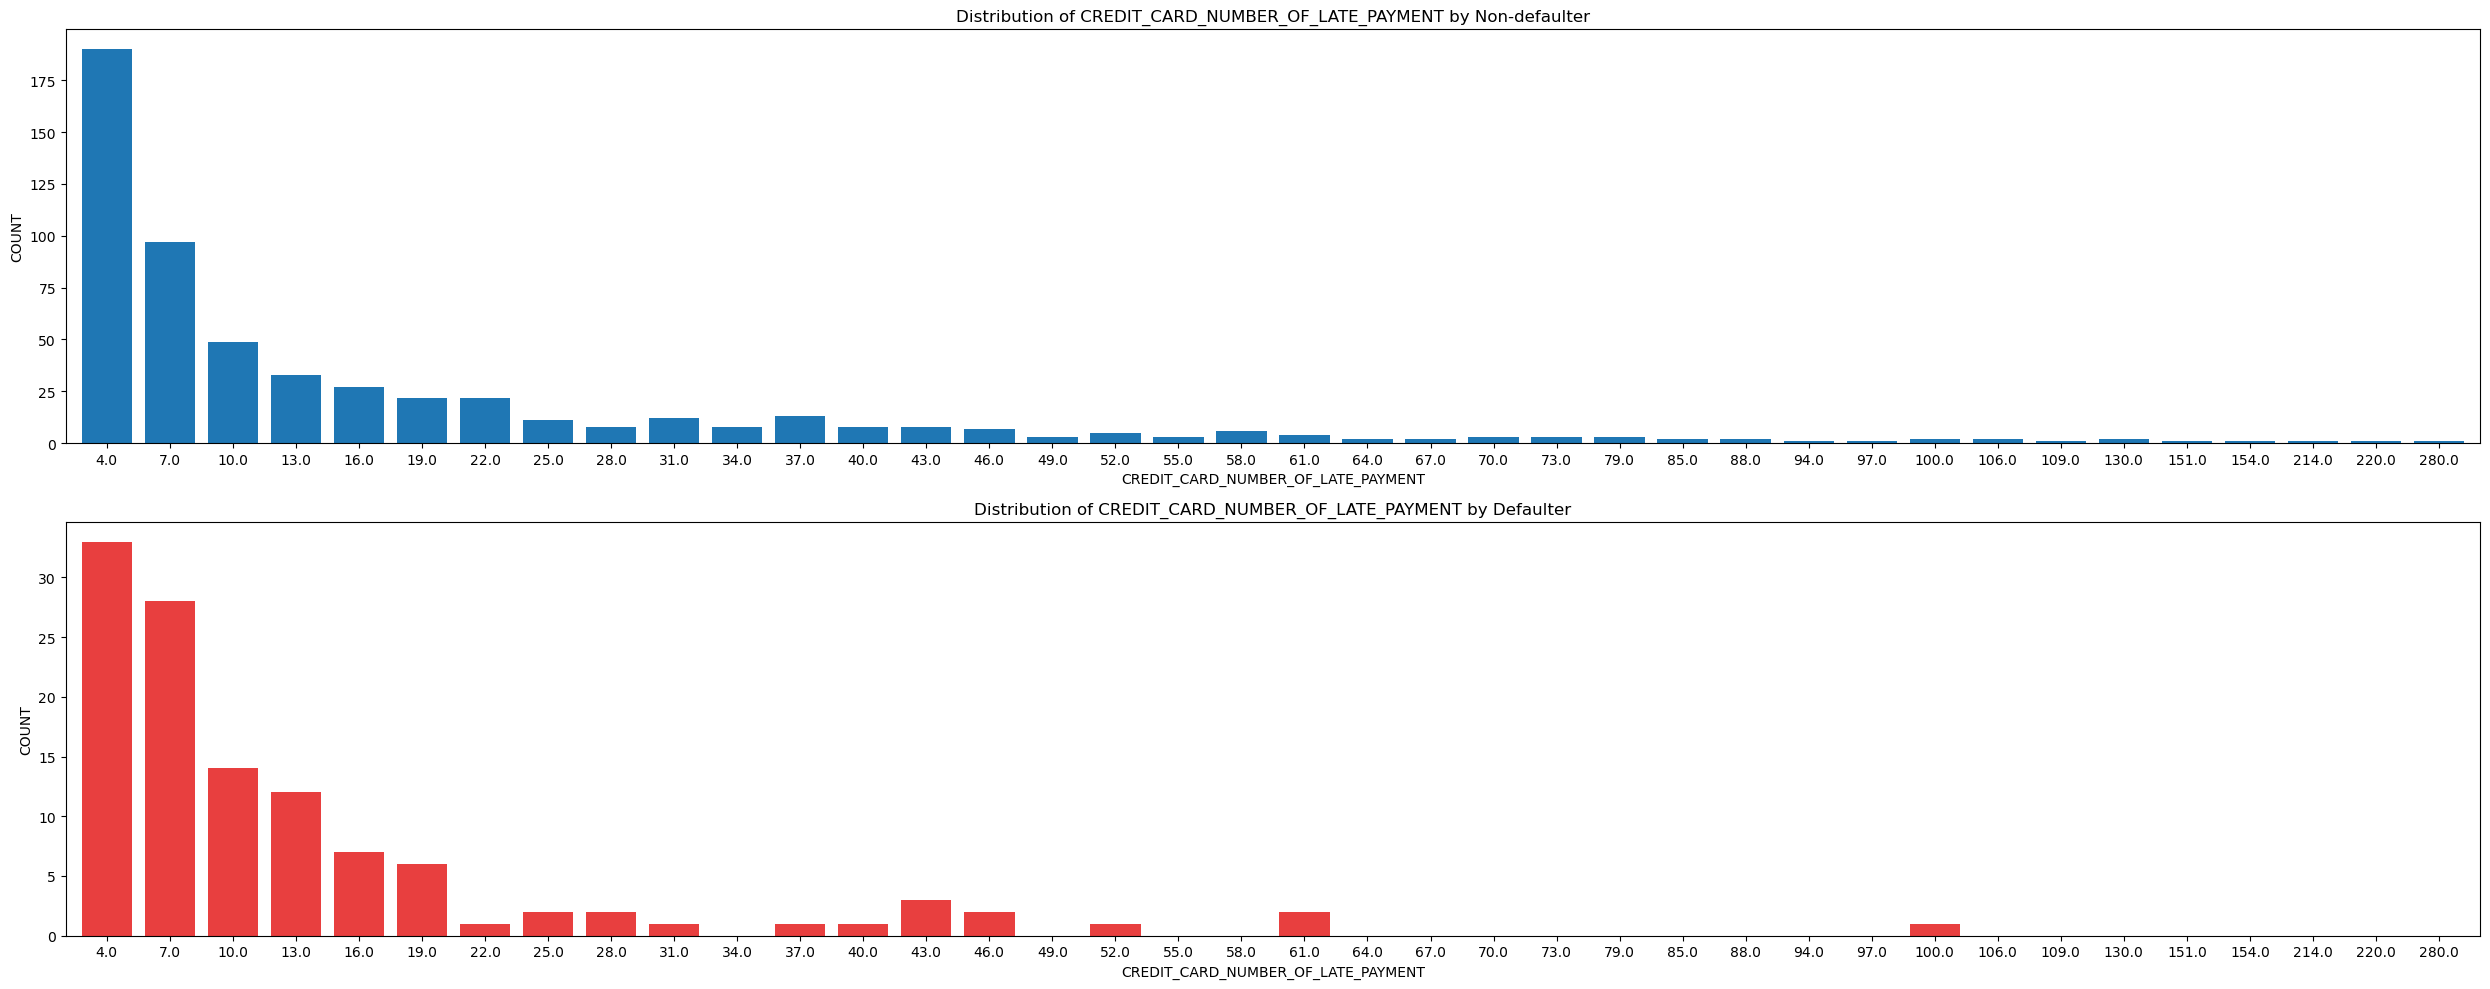

In [ ]:
columns = df.columns[df.columns.str.contains(r'^CREDIT_CARD')]
n_cols = 2
n_rows = len(columns)

# Create subplot
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the mean grouped by the binary label
col = 'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT'
d = df.loc[(df['label'] == 1) & (df[col] != 1), col].value_counts().sort_index()
nd = df.loc[(df['label'] == 0) & (df[col] != 1), col].value_counts().sort_index()

# Combine the two Series into a single DataFrame for aligned plotting
combined_df = pd.DataFrame({'Default': d, 'Non-default': nd})


# Plot for non-defaults
combined_df['Non-default'].plot(kind='bar', ax=axes[0], color='#1f77b4', width=0.8)
axes[0].set_title(f'Distribution of {col} by Non-defaulter')
axes[0].set_xlabel(col)
axes[0].set_ylabel('COUNT')
axes[0].tick_params(axis='x', rotation=0)

# Plot for defaults
combined_df['Default'].plot(kind='bar', ax=axes[1], color='#E83F3F', width=0.8)
axes[1].set_title(f'Distribution of {col} by Defaulter')
axes[1].set_xlabel(col)
axes[1].set_ylabel('COUNT')
axes[1].tick_params(axis='x', rotation=0)
# Hide any remaining empty subplots if columns don't fill the entire grid


plt.tight_layout()
plt.show()

In [ ]:
df_t = df[['CREDIT_CARD_NUMBER_OF_LATE_PAYMENT', 'label']].copy(deep=True)
df_t['many_late'] = np.where(df['CREDIT_CARD_NUMBER_OF_LATE_PAYMENT'] >= 7, 1, 0)
df_t.corr()

CREDIT_CARD_NUMBER_OF_LATE_PAYMENT  \
CREDIT_CARD_NUMBER_OF_LATE_PAYMENT                            1.000000   
label                                                        -0.015973   
many_late                                                     0.628886   

                                       label  many_late  
CREDIT_CARD_NUMBER_OF_LATE_PAYMENT -0.015973   0.628886  
label                               1.000000   0.000005  
many_late                           0.000005   1.000000

In [ ]:
# from sklearn.feature_selection import SelectKBest,mutual_info_classif
# MI model
mic = SelectKBest(score_func=mutual_info_classif,k=3)
df_t.dropna(inplace=True)
X = df_t[df_t.columns.drop('label')]
y = df_t['label']
mic.fit(X,y)
feature_MI_score = pd.Series(mic.scores_,index=X.columns)
feature_MI_score.sort_values(ascending=False)

c:\Users\trong\anaconda3\envs\pydata-book\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(


CREDIT_CARD_NUMBER_OF_LATE_PAYMENT    0.001906
many_late                             0.000000
dtype: float64

In [ ]:
df[['INCREASING_BAL_3M_LOAN', 'INCREASING_BAL_6M_LOAN']].value_counts()

INCREASING_BAL_3M_LOAN  INCREASING_BAL_6M_LOAN
1000000.0               1000000.0                 14547
1000010.0               1000000.0                  1187
                        1000010.0                   465
Name: count, dtype: int64

In [ ]:
df_t = df.copy(deep=True)
df_t['ENQUIRIES_FROM_BANK_6M_9M']

1        2.000000
2        7.000000
3        6.090909
4        2.000000
5       -3.000000
           ...   
19994    2.000000
19995   -3.000000
19996    2.000000
19997         NaN
19999    2.000000
Name: ENQUIRIES_FROM_BANK_6M_9M, Length: 15169, dtype: float64

In [ ]:
df.loc[df['label'] == 1, ['NUMBER_OF_RELATIONSHIP', 'NUMBER_OF_RELATIONSHIP_BANK','NUMBER_OF_RELATIONSHIP_NON_BANK']].describe()

NUMBER_OF_RELATIONSHIP  NUMBER_OF_RELATIONSHIP_BANK  \
count             3273.000000                  3309.000000   
mean                 6.950504                     3.388033   
std                  6.313866                     3.832014   
min                  1.000000                     1.000000   
25%                  1.000000                     1.000000   
50%                  4.000000                     1.000000   
75%                 10.000000                     4.000000   
max                 46.000000                    34.000000   

       NUMBER_OF_RELATIONSHIP_NON_BANK  
count                      3282.000000  
mean                          4.597806  
std                           4.009175  
min                           1.000000  
25%                           1.000000  
50%                           4.000000  
75%                           7.000000  
max                          25.000000

In [ ]:
df.corr()['SHORT_TERM_COUNT'].sort_values(ascending=False)

SHORT_TERM_COUNT             1.000000
SHORT_TERM_COUNT_NON_BANK    0.795530
NUMBER_OF_LOANS              0.724456
NUM_NEW_LOAN_TAKEN_12M       0.717117
SHORT_TERM_COUNT_BANK        0.716386
                               ...   
INCREASING_BAL_3M_CC        -0.090963
INCREASING_BAL_6M_ALL       -0.137661
INCREASING_BAL_6M_CC        -0.137984
INCREASING_BAL_6M_LOAN      -0.178568
label                       -0.312538
Name: SHORT_TERM_COUNT, Length: 124, dtype: float64

label
0    16356
1     3644
Name: count, dtype: int64

In [ ]:
cols = ['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT', 'label']
df_t = df[cols].copy(deep=True)
# # check so lan tre co lien quan den default khong -> fail
# df_t.loc[df_t['CREDIT_CARD_NUMBER_OF_LATE_PAYMENT'] != 1, 'label'].value_counts() / df_t['label'].value_counts()
# df_t.loc[df_t['CREDIT_CARD_NUMBER_OF_LATE_PAYMENT'] > 10, 'label'].value_counts() / df_t['label'].value_counts()
df_t

label
0    0.014123
1    0.011526
Name: count, dtype: float64

In [ ]:
# lb = 1
# df.loc[df['label'] == lb, ['NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'NUMBER_OF_CREDIT_CARDS_BANK',
#        'NUMBER_OF_CREDIT_CARDS_NON_BANK']].mean().plot(kind='barh')
# plt.xlabel('Mean')
# plt.title(f'Label = {lb}')

In [ ]:
df_t = df[['ENQUIRIES_FROM_BANK_3M_6M','ENQUIRIES_FROM_BANK_6M_9M', 'ENQUIRIES_FROM_BANK_9M_12M','ENQUIRIES_FROM_BANK_6M_12M', 'ENQUIRIES_FROM_BANK_3M_12M',
    'ENQUIRIES_FROM_BANK_3M', 'ENQUIRIES_FROM_BANK_6M', 'ENQUIRIES_FROM_BANK_9M', 'ENQUIRIES_FROM_BANK_12M',
    'label']]
df_t['ENQUIRIES_CHANGE_3M_6M'] = (df_t['ENQUIRIES_FROM_BANK_3M'] - df_t['ENQUIRIES_FROM_BANK_6M']) / df_t['ENQUIRIES_FROM_BANK_6M']
df_t

C:\Users\trong\AppData\Local\Temp\ipykernel_18792\2173842909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['ENQUIRIES_CHANGE_3M_6M'] = (df_t['ENQUIRIES_FROM_BANK_3M'] - df_t['ENQUIRIES_FROM_BANK_6M']) / df_t['ENQUIRIES_FROM_BANK_6M']


ENQUIRIES_FROM_BANK_3M_6M  ENQUIRIES_FROM_BANK_6M_9M  \
0                            NaN                        NaN   
1                      -3.000000                   2.000000   
2                       7.000000                   7.000000   
3                       4.222222                   6.090909   
4                       2.000000                   2.000000   
...                          ...                        ...   
19995                  -3.000000                  -3.000000   
19996                   2.000000                   2.000000   
19997                   4.222222                        NaN   
19998                   4.500000                   7.000000   
19999                  -3.000000                   2.000000   

       ENQUIRIES_FROM_BANK_9M_12M  ENQUIRIES_FROM_BANK_6M_12M  \
0                        2.000000                    2.000000   
1                        7.000000                    2.000000   
2                        5.571429                    5.571429   
3                        7.000000                         NaN   
4                        2.000000                    2.000000   
...                           ...                         ...   
19995                         NaN                         NaN   
19996                         NaN                    2.000000   
19997                    7.000000                    7.000000   
19998                    4.857143                    4.857143   
19999                         NaN                         NaN   

       ENQUIRIES_FROM_BANK_3M_12M  ENQUIRIES_FROM_BANK_3M  \
0                        2.000000                     2.0   
1                        2.000000                     2.0   
2                        5.571429                    27.0   
3                             NaN                    22.0   
4                        2.000000                     2.0   
...                           ...                     ...   
19995                   -3.000000                     2.0   
19996                    2.000000                     NaN   
19997                    4.222222                     NaN   
19998                    3.428571                    12.0   
19999                    2.000000                     2.0   

       ENQUIRIES_FROM_BANK_6M  ENQUIRIES_FROM_BANK_9M  \
0                         2.0                     2.0   
1                         NaN                    12.0   
2                        27.0                    27.0   
3                        47.0                    57.0   
4                         2.0                     2.0   
...                       ...                     ...   
19995                     2.0                     2.0   
19996                     2.0                     2.0   
19997                    47.0                    47.0   
19998                    22.0                    22.0   
19999                     2.0                     NaN   

       ENQUIRIES_FROM_BANK_12M  label  ENQUIRIES_CHANGE_3M_6M  
0                          2.0      1                0.000000  
1                         12.0      0                     NaN  
2                         37.0      0                0.000000  
3                         57.0      0               -0.531915  
4                          2.0      1                0.000000  
...                        ...    ...                     ...  
19995                      2.0      0                0.000000  
19996                      NaN      0                     NaN  
19997                     47.0      0                     NaN  
19998                     37.0      0               -0.454545  
19999                     12.0      1                0.000000  

[20000 rows x 11 columns]

<Axes: >

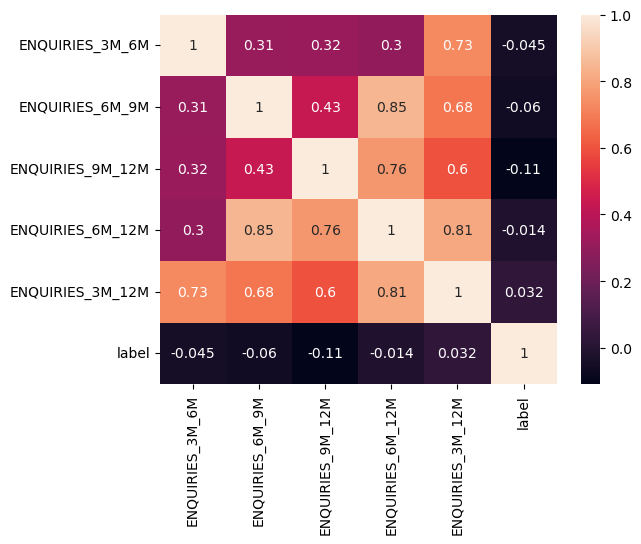

In [ ]:
sns.heatmap(df[['ENQUIRIES_3M_6M', 'ENQUIRIES_6M_9M', 'ENQUIRIES_9M_12M',
       'ENQUIRIES_6M_12M', 'ENQUIRIES_3M_12M', 'label']].corr(), annot=True)

In [ ]:
df_t = df[['NUMBER_OF_LOANS', 'NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M', 'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M']]
big_3m = df_t['NUMBER_OF_LOANS'] < df_t['NUM_NEW_LOAN_TAKEN_3M']
big_6m = df_t['NUMBER_OF_LOANS'] < df_t['NUM_NEW_LOAN_TAKEN_6M']
big_9m = df_t['NUMBER_OF_LOANS'] < df_t['NUM_NEW_LOAN_TAKEN_9M']
big_12m = df_t['NUMBER_OF_LOANS'] < df_t['NUM_NEW_LOAN_TAKEN_12M']
df_t2 = df_t[big_3m | big_6m | big_9m | big_12m]
df_t2

NUMBER_OF_LOANS  NUM_NEW_LOAN_TAKEN_3M  NUM_NEW_LOAN_TAKEN_6M  \
7                 19.0                    7.0                   16.0   
20                13.0                    NaN                   13.0   
34                 4.0                    4.0                    NaN   
55                10.0                   10.0                   10.0   
137                7.0                   10.0                   10.0   
...                ...                    ...                    ...   
19931              7.0                    NaN                    4.0   
19933             10.0                   10.0                   10.0   
19936             16.0                    4.0                   13.0   
19992             13.0                    1.0                    NaN   
19998             13.0                   10.0                   13.0   

       NUM_NEW_LOAN_TAKEN_9M  NUM_NEW_LOAN_TAKEN_12M  
7                       19.0                    22.0  
20                      16.0                    16.0  
34                       7.0                     7.0  
55                      13.0                    13.0  
137                     10.0                    10.0  
...                      ...                     ...  
19931                   10.0                    10.0  
19933                   10.0                    13.0  
19936                   13.0                    19.0  
19992                   16.0                    16.0  
19998                   13.0                    16.0  

[1368 rows x 5 columns]

<Axes: >

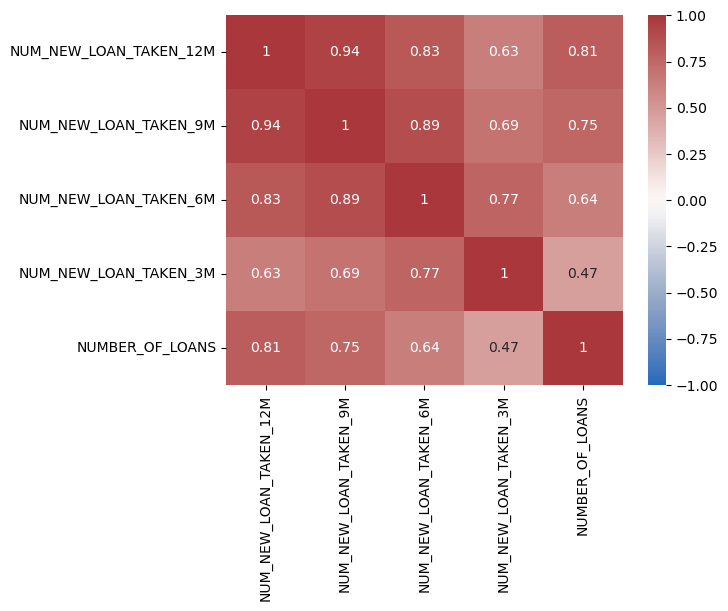

In [ ]:
df_t = df[['NUM_NEW_LOAN_TAKEN_12M',
 'NUM_NEW_LOAN_TAKEN_9M',
 'NUM_NEW_LOAN_TAKEN_6M',
 'NUM_NEW_LOAN_TAKEN_3M',
 'NUMBER_OF_LOANS']]
# plt.figure(figsize=(14,7))
# sns.lineplot(df_t.mean())
sns.heatmap(df_t.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True)

In [ ]:
df_t = df.loc[df['label'] == 0, ['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']]
df_t[df_t.sum(axis=1) >= 4]['LONG_TERM_COUNT'].dropna()

3        1.0
10       1.0
11       1.0
12       1.0
13       1.0
        ... 
19992    1.0
19995    1.0
19996    1.0
19997    1.0
19998    1.0
Name: LONG_TERM_COUNT, Length: 13797, dtype: float64

In [ ]:
df_t.sum(axis=1)

0        3.0
4        1.0
16       2.0
17       3.0
23       3.0
        ... 
19982    6.0
19989    6.0
19993    8.0
19994    2.0
19999    6.0
Length: 3644, dtype: float64

In [ ]:
df[df['label'] == 1]

customer_id  label  SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
0             1639      1               1.0             1.0              1.0   
4             1538      1               NaN             NaN              1.0   
16            2000      1               1.0             NaN              1.0   
17            1111      1               1.0             1.0              1.0   
23             646      1               1.0             1.0              1.0   
...            ...    ...               ...             ...              ...   
19982        21951      1               1.0             4.0              1.0   
19989        23381      1               4.0             1.0              1.0   
19993        15462      1               4.0             4.0              NaN   
19994          955      1               1.0             1.0              NaN   
19999        18772      1               1.0             4.0              1.0   

       SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
0                        1.0                  1.0                   1.0   
4                        1.0                  1.0                   1.0   
16                       NaN                  1.0                   1.0   
17                       1.0                  1.0                   1.0   
23                       1.0                  1.0                   1.0   
...                      ...                  ...                   ...   
19982                    1.0                  1.0                   1.0   
19989                    1.0                  1.0                   1.0   
19993                    4.0                  4.0                   4.0   
19994                    1.0                  1.0                   NaN   
19999                    1.0                  1.0                   1.0   

       SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  ...  \
0                            1.0                      1.0  ...   
4                            1.0                      4.0  ...   
16                           1.0                      1.0  ...   
17                           1.0                      1.0  ...   
23                           1.0                      1.0  ...   
...                          ...                      ...  ...   
19982                        1.0                      4.0  ...   
19989                        4.0                      1.0  ...   
19993                        NaN                      1.0  ...   
19994                        1.0                      1.0  ...   
19999                        1.0                      4.0  ...   

       ENQUIRIES_FROM_BANK_6M_9M  ENQUIRIES_FROM_BANK_9M_12M  \
0                            NaN                         2.0   
4                            2.0                         2.0   
16                           2.0                         2.0   
17                           2.0                         2.0   
23                           2.0                         2.0   
...                          ...                         ...   
19982                       -3.0                        -3.0   
19989                       -3.0                        -3.0   
19993                        7.0                         7.0   
19994                        2.0                         2.0   
19999                        2.0                         NaN   

       ENQUIRIES_FROM_BANK_6M_12M  ENQUIRIES_FROM_BANK_3M_12M  \
0                             2.0                         2.0   
4                             2.0                         2.0   
16                            2.0                         NaN   
17                            2.0                         2.0   
23                            2.0                         2.0   
...                           ...                         ...   
19982                        -3.0                        -3.0   
19989                        -3.0                        -3.0  

In [ ]:
df.columns[df.columns.str.contains('ENQ')]

Index(['ENQUIRIES_3M', 'ENQUIRIES_6M', 'ENQUIRIES_9M', 'ENQUIRIES_12M',
       'ENQUIRIES_FROM_BANK_3M', 'ENQUIRIES_FROM_NON_BANK_3M',
       'ENQUIRIES_FOR_LOAN_3M', 'ENQUIRIES_FOR_CC_3M',
       'ENQUIRIES_FROM_BANK_FOR_LOAN_3M',
       'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_3M', 'ENQUIRIES_FROM_BANK_FOR_CC_3M',
       'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M', 'ENQUIRIES_FROM_BANK_6M',
       'ENQUIRIES_FROM_NON_BANK_6M', 'ENQUIRIES_FOR_LOAN_6M',
       'ENQUIRIES_FOR_CC_6M', 'ENQUIRIES_FROM_BANK_FOR_LOAN_6M',
       'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M', 'ENQUIRIES_FROM_BANK_FOR_CC_6M',
       'ENQUIRIES_FROM_NON_BANK_FOR_CC_6M', 'ENQUIRIES_FROM_BANK_9M',
       'ENQUIRIES_FROM_NON_BANK_9M', 'ENQUIRIES_FOR_LOAN_9M',
       'ENQUIRIES_FOR_CC_9M', 'ENQUIRIES_FROM_BANK_FOR_LOAN_9M',
       'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_9M', 'ENQUIRIES_FROM_BANK_FOR_CC_9M',
       'ENQUIRIES_FROM_NON_BANK_FOR_CC_9M', 'ENQUIRIES_FROM_BANK_12M',
       'ENQUIRIES_FROM_NON_BANK_12M', 'ENQUIRIES_FOR_LOAN_12M',
  

In [ ]:
df[df['ENQUIRIES_FROM_BANK_6M_9M'] == -3]['label'].value_counts()

label
0    6758
1     701
Name: count, dtype: int64

In [ ]:
['NUM_NEW_LOAN_TAKEN_12M',
 'NUM_NEW_LOAN_TAKEN_9M',
 'NUM_NEW_LOAN_TAKEN_6M',
 'NUM_NEW_LOAN_TAKEN_3M',
 'NUMBER_OF_LOANS'][::-1]

['NUMBER_OF_LOANS',
 'NUM_NEW_LOAN_TAKEN_3M',
 'NUM_NEW_LOAN_TAKEN_6M',
 'NUM_NEW_LOAN_TAKEN_9M',
 'NUM_NEW_LOAN_TAKEN_12M']

In [ ]:
cols = ['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD', 'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD',
        'NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M',
        'NUMBER_OF_LOANS', 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'label']
df_tt = df[cols]
df_tt.fillna(0, inplace=True)
df_tt['solve'] = df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M',]].sum(axis=1) - df[[ 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].sum(axis=1)
df_tt['solve'] = np.where(df_tt['solve'] < 0, 0, df_tt['solve'])
df_tt['psolve'] = df_tt['solve'] / df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M',]].sum(axis=1)

# df_tt['ps'] = df_tt['SHORT_TERM_COUNT'] / df_tt[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'solve']].sum(axis=1)
# df_tt['p12m'] = df_tt['NUM_NEW_LOAN_TAKEN_12M'] / df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M']].sum(axis=1)
# df_tt['theories'] = (df_tt['ps'] / df_tt['p12m'])
df_tt
df_tt.groupby('label', as_index=False)['psolve'].mean()
df_tt[['label', 'solve']].corr()
# df_tt


C:\Users\trong\AppData\Local\Temp\ipykernel_18792\91035860.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tt.fillna(0, inplace=True)
C:\Users\trong\AppData\Local\Temp\ipykernel_18792\91035860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tt['solve'] = df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M',]].sum(axis=1) - df[[ 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].sum(axis=1)
C:\Users\trong\AppData\Local\Temp\ipykernel_18792\91035860.py:7: SettingWithCopyWarning: 
A value is tr

label     solve
label  1.000000 -0.217011
solve -0.217011  1.000000

In [ ]:
a = df_tt[df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M',]].sum(axis=1) - df[[ 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].sum(axis=1) <= 0]
a['label'].value_counts()

label
0    1976
1     759
Name: count, dtype: int64

In [ ]:
a = df_tt[['NUM_NEW_LOAN_TAKEN_12M', 'NUM_NEW_LOAN_TAKEN_9M','NUM_NEW_LOAN_TAKEN_6M','NUM_NEW_LOAN_TAKEN_3M']].sum(axis=1).reset_index()
a[a[0] == 0]

index    0
10991  10991  0.0
18479  18479  0.0
19471  19471  0.0

#### T

In [ ]:
df.columns[df.columns.str.contains('MONTH')]

Index(['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD'],
      dtype='object')

In [ ]:
df[['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD']]

CREDIT_CARD_MONTH_SINCE_10DPD  CREDIT_CARD_MONTH_SINCE_30DPD  \
0                              431.0                          431.0   
1                              431.0                          431.0   
2                              431.0                          431.0   
3                                NaN                          431.0   
4                              431.0                          431.0   
...                              ...                            ...   
19995                          431.0                            NaN   
19996                          431.0                          431.0   
19997                          431.0                          431.0   
19998                          431.0                          431.0   
19999                          431.0                          431.0   

       CREDIT_CARD_MONTH_SINCE_60DPD  CREDIT_CARD_MONTH_SINCE_90DPD  
0                              431.0                          431.0  
1                              431.0                          431.0  
2                              431.0                          431.0  
3                              431.0                          431.0  
4                              431.0                          431.0  
...                              ...                            ...  
19995                          431.0                          431.0  
19996                          431.0                          431.0  
19997                          431.0                          431.0  
19998                          431.0                          431.0  
19999                          431.0                          431.0  

[20000 rows x 4 columns]

In [ ]:
df[df['OUTSTANDING_BAL_LOAN_CURRENT'] + df['OUTSTANDING_BAL_CC_CURRENT'] >= df['OUTSTANDING_BAL_ALL_CURRENT'] ]

customer_id  label  SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
0             1639      1               1.0             1.0              1.0   
2            19474      0               7.0             7.0              NaN   
3            15505      0               7.0             1.0              1.0   
4             1538      1               NaN             NaN              1.0   
6            20339      0               4.0            10.0              NaN   
...            ...    ...               ...             ...              ...   
19995        13215      0               4.0             1.0              1.0   
19996          938      0               4.0             1.0              1.0   
19997        11823      0               7.0             1.0              1.0   
19998        14609      0              10.0             4.0              1.0   
19999        18772      1               1.0             4.0              1.0   

       SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
0                        1.0                  1.0                   1.0   
2                        7.0                  NaN                   1.0   
3                        NaN                  1.0                   NaN   
4                        1.0                  1.0                   1.0   
6                        1.0                  4.0                   1.0   
...                      ...                  ...                   ...   
19995                    4.0                  1.0                   1.0   
19996                    1.0                  1.0                   1.0   
19997                    4.0                  1.0                   1.0   
19998                   10.0                  1.0                   1.0   
19999                    1.0                  1.0                   1.0   

       SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  ...  \
0                            1.0                      1.0  ...   
2                            1.0                      4.0  ...   
3                            7.0                      1.0  ...   
4                            1.0                      4.0  ...   
6                            4.0                      7.0  ...   
...                          ...                      ...  ...   
19995                        1.0                      1.0  ...   
19996                        NaN                      1.0  ...   
19997                        4.0                      1.0  ...   
19998                        1.0                      NaN  ...   
19999                        1.0                      4.0  ...   

       ENQUIRIES_FROM_BANK_6M_9M  ENQUIRIES_FROM_BANK_9M_12M  \
0                            NaN                    2.000000   
2                       7.000000                    5.571429   
3                       6.090909                    7.000000   
4                       2.000000                    2.000000   
6                       5.000000                    7.000000   
...                          ...                         ...   
19995                  -3.000000                         NaN   
19996                   2.000000                         NaN   
19997                        NaN                    7.000000   
19998                   7.000000                    4.857143   
19999                   2.000000                         NaN   

       ENQUIRIES_FROM_BANK_6M_12M  ENQUIRIES_FROM_BANK_3M_12M  \
0                        2.000000                    2.000000   
2                        5.571429                    5.571429   
3                             NaN                         NaN   
4                        2.000000                    2.000000   
6                        5.000000                    2.666667   
...                           ...                         ...   
19995                         NaN                   -3.000000   
19996                    2.000000                    2.000000  

In [ ]:
df.shape

(15169, 124)